
# 수면 설문 데이터 자동화 EDA 노트북

## 변경사항
- ver2 : 데이터 8:2로 나눠서 CFA용 데이터 분리, hh:mm 타입 값은 평균값과의 상대적 차이로 전환, 카테고리 값도 전부 연속값 취급하여 요인분석에 바로 포함
- ver3 : KNO/Bartlett 이용한 요인분석 적합성 검정 추가, 계층적 요인분석 및 요인점수 적합 추가
- ver4 : EFA 확인 위해 변수 할당 수작업으로 진행하는 부분 추가, CFA를 위한 정제 쪽에서 overlap_mode 대신 cross-loading_thr로 조건 변경
  - 여기선 `factor_analyzer`을 사용하여 CFA 돌린 후 적재량 추정치가 같은 모습으로 나오는지 확인하기 (이중EFA 부분은 일단 제거)

이 노트북은 **변수 메타데이터(범주형/연속형/설명) 엑셀**을 활용해 다음을 자동으로 수행합니다.
1. 데이터/메타데이터 로드 및 타입 변환
2. 기술통계 요약 (범주형 vs 연속형)
3. 자동 시각화 (히스토그램, 카운트 플롯, 박스플롯)
4. 기본 집단 비교 (교대 vs 비교대, 성별)
5. 상관 히트맵 및 (선택) 요인분석(EFA), 카이제곱 검정

> **사용 전 준비**  
> - 설문 데이터 파일 경로 (예: `sleep_survey.xlsx`)  
> - 변수 메타데이터 파일 경로 (예: `variables_meta.xlsx`)  
> - 메타 파일에는 최소한 다음 컬럼이 있어야 합니다: `변수명`, `범주형`, `연속형`, `타입`, `변수설명`


근데 이제 여기선 범주별 EFA 돌려서 1factor, 혹은 더 많은 축으로 돌린 뒤 '설명력' 을 확인해볼 것

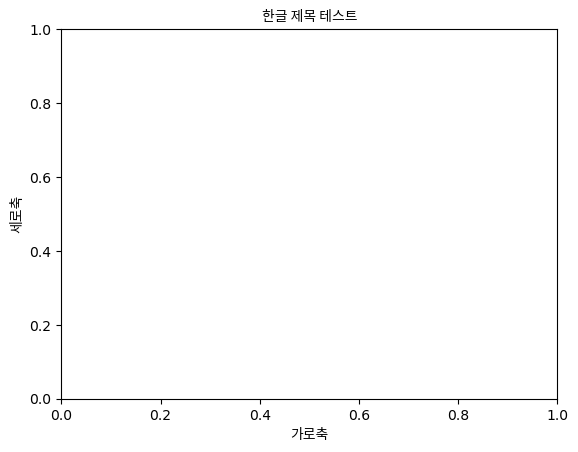

In [1]:
# 폰트 설정

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager as fm
from matplotlib import rcParams

fp = FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")

plt.title("한글 제목 테스트", fontproperties=fp)
plt.xlabel("가로축", fontproperties=fp)
plt.ylabel("세로축", fontproperties=fp)
plt.show()

fp = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
rcParams['font.family'] = fp.get_name()   # 파일에서 읽은 실제 이름 등록
rcParams['axes.unicode_minus'] = False

In [2]:

# ==== 경로 설정 ====
# DATA_FILE = "/home/hschoi/data/leehyunwon/SleepHi/ver2/sleephi_ver2_data_2018_2nd.xlsx"         # 설문 데이터(.xlsx) # 날짜 형식 문제 있으면 _edited 사용할 것으로 예상했으나 코드 문제로 보임
# META_FILE = "/home/hschoi/data/leehyunwon/SleepHi/ver2/sleephi_ver2_variable_2018_2nd.xlsx"       # 변수 메타데이터(.xlsx)

# 이전에 받은 데이터용
DATA_FILE = "/home/hschoi/data/leehyunwon/SleepHi/Sleep Hi_KSHS_2nd_data_250811.xlsx"         # 설문 데이터(.xlsx) # 날짜 형식 문제 있으면 _edited 사용할 것으로 예상했으나 코드 문제로 보임
META_FILE = "/home/hschoi/data/leehyunwon/SleepHi/Sleep Hi_Variable_250811.xlsx"       # 변수 메타데이터(.xlsx)

# OUT_DIR = "eda_results"                 # 결과 이미지 저장 폴더

# ==== 라이브러리 ====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import re
from sklearn.impute import SimpleImputer
from pandas.api.types import (
    is_datetime64_any_dtype, is_timedelta64_dtype,
    is_object_dtype, is_numeric_dtype
)
import re
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import (
    is_datetime64_any_dtype, is_timedelta64_dtype,
    is_object_dtype, is_numeric_dtype
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp
from stepmix.stepmix import StepMix
from sklearn.model_selection import train_test_split
from itertools import zip_longest

# 선택 라이브러리 (미설치 시 주석 처리 가능)
try:
    from factor_analyzer import FactorAnalyzer
    HAS_FACTOR = True
except Exception:
    HAS_FACTOR = False
    print("[알림] factor_analyzer가 설치되어 있지 않습니다. (pip install factor-analyzer)")

# # 한글 폰트 설정 (환경에 따라 주석 필요)
# plt.rcParams['font.family'] = 'Noto Sans CJK KR'  # 환경에 맞게 변경하세요
# plt.rcParams['axes.unicode_minus'] = False

# os.makedirs(OUT_DIR, exist_ok=True)
print("환경 준비 완료.")


환경 준비 완료.


In [3]:

# ==== 데이터/메타데이터 로드 ====
df = pd.read_excel(DATA_FILE)
meta = pd.read_excel(META_FILE)

print("데이터 크기:", df.shape)
print("컬럼 예시:", df.columns[:10].tolist())

# 메타 필수 컬럼 체크
required_cols = {"변수명", "범주형", "연속형"}
missing_meta_cols = required_cols - set(meta.columns)
if missing_meta_cols:
    raise ValueError(f"메타데이터에 필요한 컬럼이 없습니다: {missing_meta_cols}")

# 범주/연속 변수 리스트
categorical_vars = meta.loc[meta["범주형"] == 1, "변수명"].dropna().astype(str).tolist()
continuous_vars = meta.loc[meta["연속형"] == 1, "변수명"].dropna().astype(str).tolist()

# 실제 df에 존재하는 컬럼만 사용
categorical_vars = [c for c in categorical_vars if c in df.columns]
continuous_vars = [c for c in continuous_vars if c in df.columns]

print("범주형 변수 개수:", len(categorical_vars))
print("연속형 변수 개수:", len(continuous_vars))


데이터 크기: (2501, 97)
컬럼 예시: ['ID', 'SW', 'sex', 'age', 'age_group', 'Q59_1_w', 'Q59_1_f', 'D3_1_ht', 'D3_2_wt', 'BMI']
범주형 변수 개수: 21
연속형 변수 개수: 75


In [4]:
# 누락변수 있으면 확인 후 제거 (ID는 원래 제외하는게 맞음)
print(set(df.columns) - set(categorical_vars + continuous_vars))

df.drop(set(df.columns) - set(categorical_vars + continuous_vars), axis=1, inplace=True)

{'ID'}


In [5]:
# 특정 열의 값 하나 출력
print("예시 값:", df["MCTQ_GUa"].values[:5])
print("예시 값:", df["MCTQ_MSF"].values[:5])
print("예시 값:", df["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df["MCTQ_MBF"].values[:5])
# print("예시 값:", df["MCTQ_SOf_c"].values[:5]) # ver2 변수에선 없음
print("예시 값:", df["MCTQ_SOa_c"].values[:5])
# print("예시 값:", df["MCTQ_SOw_c"].values[:5]) # ver2 변수에선 없음
# print("예시 값:", df["MCTQ_TFPw"].values[:5]) # ver2 변수에선 없음


# print("예시 값:", df_copy["MCTQ_GUa"].values[:5])
# print("예시 값:", df_copy["MCTQ_MSF"].values[:5])
# print("예시 값:", df_copy["MSF_mismatch_pristine"].values[:5])
# print("예시 값:", df_copy["MCTQ_MBF"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOf_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOa_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOw_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_TFPw"].values[:5])

예시 값: [datetime.time(10, 30) datetime.time(9, 4, 17, 143000)
 datetime.time(8, 22, 8, 571000) datetime.time(9, 55, 51, 429000)
 datetime.time(8, 18, 34, 286000)]
예시 값: [datetime.time(5, 40) datetime.time(5, 5) datetime.time(4, 32, 30)
 datetime.time(8, 20) datetime.time(4, 20)]
예시 값: [datetime.time(2, 10) datetime.time(0, 35) datetime.time(0, 2, 30)
 datetime.time(2, 50) datetime.time(0, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 5, 45) datetime.datetime(1900, 1, 1, 4, 50)
 datetime.datetime(1900, 1, 1, 4, 32, 30)
 datetime.datetime(1900, 1, 1, 8, 1, 30)
 datetime.datetime(1900, 1, 1, 4, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 1, 28, 34, 286000)
 datetime.datetime(1900, 1, 1, 0, 4, 17, 143000)
 datetime.datetime(1900, 1, 1, 0, 5)
 datetime.datetime(1900, 1, 1, 3, 25, 42, 857000)
 datetime.datetime(1900, 1, 1, 0, 10)]


# 결측치 관리 : 평균or0처리, 아니면 결측치 전부 제거(일단 후자로 진행)

In [6]:
# # 결측치 평균값으로 두고 아예 없으면 0으로 두기, 하고 나서 위에 결측치 플롯 다시 해보기 (카테고리 값은 제외되었으니 위의 플롯에 카테고리만 보일 것)

# # Get a list of only the numeric columns
# numeric_cols = df.select_dtypes(include=np.number).columns

# # Loop through the numeric columns
# for column in numeric_cols:
#     # Calculate the mean of the column, ignoring NaNs
#     mean_value = df[column].mean()

#     # If the mean is NaN (the entire column is null), set it to 0
#     if pd.isna(mean_value):
#         mean_value = 0

#     # Fill the null values in the column with the calculated mean
#     df[column].fillna(mean_value, inplace=True)

In [7]:
# 이번엔 다른 작업, 하나라도 NaN이 있으면 해당 행 제거
df_clean = df.dropna()

print("원래 행 개수:", len(df))
print("결측치 제거 후 행 개수:", len(df_clean))


df = df_clean.copy()

원래 행 개수: 2501
결측치 제거 후 행 개수: 2363


# 시간 값 변환

In [8]:
# 숫자 duration(ns/us/ms/s/h/min)을 원소별 '분'으로 환산
def _numeric_duration_to_minutes_elwise(arr: pd.Series) -> pd.Series:
    v = pd.to_numeric(arr, errors="coerce").astype("float").to_numpy()
    out = np.full_like(v, np.nan, dtype="float64")
    a = np.abs(v)

    ns = (a >= 1e11)                             # 예: 1.8e12 ≈ 30분(ns)
    us = (~ns) & (a >= 1e8)                      # μs
    ms = (~ns) & (~us) & (a >= 1e6)              # ms
    sec= (~ns) & (~us) & (~ms) & (a >= 60)       # s
    minute = (~ns) & (~us) & (~ms) & (~sec) & (a > 0) & (a <= 24*60)
    hour   = (~ns) & (~us) & (~ms) & (~sec) & (~minute) & (a > 0)

    out[ns]     = v[ns]    / (1e9 * 60.0)
    out[us]     = v[us]    / (1e6 * 60.0)
    out[ms]     = v[ms]    / (1e3 * 60.0)
    out[sec]    = v[sec]   / 60.0
    out[minute] = v[minute]
    out[hour]   = v[hour]  * 60.0

    # 0은 유효값
    out[np.isfinite(v) & (v == 0)] = 0.0
    return pd.Series(out, index=arr.index)

_hhmm_pat = re.compile(r"^(\d{1,2}):(\d{2})(?::(\d{2})(?:\.(\d+)?)?)?$")

def _safe_to_minutes_scalar(x):
    """단일 값 x를 '분(float)'으로. 해석 불가 시 np.nan (→ 열 전체 변환 스킵 트리거)."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan

    # python datetime/time
    if isinstance(x, dt.time):
        return x.hour*60 + x.minute + x.second/60.0
    if isinstance(x, dt.datetime):
        return x.hour*60 + x.minute + x.second/60.0

    # pandas 계열
    if isinstance(x, pd.Timestamp):
        return x.hour*60 + x.minute + x.second/60.0
    if isinstance(x, pd.Timedelta):
        return x.total_seconds()/60.0
    if isinstance(x, np.datetime64):
        try:
            ts = pd.to_datetime(x)
            return ts.hour*60 + ts.minute + ts.second/60.0
        except Exception:
            return np.nan

    # 숫자: duration 단위 추정
    if isinstance(x, (int, float, np.integer, np.floating)):
        if np.isnan(x): 
            return np.nan
        v = float(x); av = abs(v)
        if av >= 1e11: return v/(1e9*60.0) # ns
        if av >= 1e8:  return v/(1e6*60.0) # μs
        if av >= 1e6:  return v/(1e3*60.0) # ms
        if av >= 60:   return v/60.0       # s
        if 0 <= v <= 24*60: return v       # 분
        return v*60.0                       # 시간

    # 문자열: timedelta → datetime → HH:MM(:SS) → 숫자 문자열
    if isinstance(x, str):
        sx = x.strip()
        if not sx:
            return np.nan
        try:
            td = pd.to_timedelta(sx)
            if isinstance(td, pd.Timedelta) or hasattr(td, "components"):
                return float(td.total_seconds())/60.0
        except Exception:
            pass
        try:
            ts = pd.to_datetime(sx)
            if isinstance(ts, pd.Timestamp):
                return ts.hour*60 + ts.minute + ts.second/60.0
        except Exception:
            pass
        m = _hhmm_pat.match(sx)
        if m:
            h, m_, s_ = int(m.group(1)), int(m.group(2)), int(m.group(3) or 0)
            return h*60 + m_ + s_/60.0
        try:
            fv = float(sx.replace(",", ""))
            return _safe_to_minutes_scalar(fv)
        except Exception:
            return np.nan

    return np.nan

def series_to_minutes_strict(s: pd.Series) -> (pd.Series, pd.Series):
    """
    시리즈 전체를 '분'으로 변환.
    - dtype별 최적 경로 사용, object 혼합은 원소별 안전 파서 사용
    - 반환: (minutes_series, ok_mask) ; ok_mask=False가 하나라도 있으면 열 전체 변환 스킵
    """
    if is_timedelta64_dtype(s):
        out = (s.dt.total_seconds() / 60.0).astype("float")
        ok = s.notna() | (out == 0.0)
        return out, ok

    if is_datetime64_any_dtype(s):
        out = (s.dt.hour*60 + s.dt.minute + s.dt.second/60.0).astype("float")
        ok = s.notna() | (out == 0.0)
        return out, ok

    if is_numeric_dtype(s):
        out = _numeric_duration_to_minutes_elwise(s).astype("float")
        ok = out.notna() | (out == 0.0)
        return out, ok

    # object 혼합형: 안전 파서로 원소별 처리
    out = s.map(_safe_to_minutes_scalar).astype("float")
    ok  = out.notna() | (out == 0.0)
    return out, ok

def looks_time_like_series(s: pd.Series, sample_n: int = 200) -> bool:
    """연속형 후보 중 '시간/지속시간'으로 보이는지 휴리스틱 판정."""
    if is_datetime64_any_dtype(s) or is_timedelta64_dtype(s):
        return True
    if is_object_dtype(s):
        smp = s.dropna().astype(str).head(sample_n)
        if smp.empty: 
            return False
        if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
            return True
        has_dt_like = s.dropna().map(lambda v: isinstance(v, (dt.time, dt.datetime, pd.Timestamp, pd.Timedelta, np.datetime64))).any()
        if has_dt_like:
            return True
    if is_numeric_dtype(s):
        smp = s.dropna().astype(float).abs().head(sample_n)
        if smp.empty:
            return False
        if (smp.ge(1e6).mean() > 0.05) or (smp.between(0, 24*60).mean() > 0.5):
            return True
    return False

def convert_time_columns_inplace_for_efa(df: pd.DataFrame, continuous_vars: list):
    """
    - continuous_vars 중 시간/지속시간으로 보이는 열만 골라 in-place로 분(float)로 변환
    - 한 값이라도 실패하면 그 열은 변환하지 않음(원본 유지)
    - 반환: {'converted': [...], 'skipped': [...], 'issues': DataFrame, 'efa_cols': [...]}
    """
    converted, skipped, issues = [], [], []

    # 시간/지속시간 후보만 선별
    time_like_candidates = [c for c in continuous_vars if c in df.columns and not is_numeric_dtype(df[c]) and looks_time_like_series(df[c])]

    for col in time_like_candidates:
        minutes, ok = series_to_minutes_strict(df[col])
        if ok.all():
            # 원본 열을 '분(float)'로 덮어쓰기
            df[col] = minutes.astype("float")
            converted.append(col)
        else:
            skipped.append(col)
            bad = ~ok
            bad_examples = df.loc[bad, col].astype(str).value_counts().head(10)
            issues.append({
                "column": col,
                "n_total": int(len(df)),
                "n_failed": int(bad.sum()),
                "examples": "; ".join([f"{k} x{v}" for k, v in bad_examples.items()])
            })

    # EFA에 실제로 투입 가능한 연속형 열(숫자형만)
    efa_cols = [c for c in continuous_vars if c in df.columns and is_numeric_dtype(df[c])]

    issues_df = pd.DataFrame(issues).sort_values("n_failed", ascending=False) if issues else pd.DataFrame(columns=["column","n_total","n_failed","examples"])

    return {
        "converted": converted,
        "skipped": skipped,
        "issues": issues_df,
        "efa_cols": efa_cols
    }

# ===== 실행부 =====
# continuous_vars는 질문에서 이미 만들어져 있다고 가정
report = convert_time_columns_inplace_for_efa(df, continuous_vars)

print("[변환 완료 요약]")
print("  변환 성공 열 수:", len(report["converted"]))
if report["converted"]:
    print("   └", report["converted"])

print("  변환 스킵 열 수:", len(report["skipped"]))
if report["skipped"]:
    print("   └", report["skipped"])
    print("\n[스킵 사유(문제 값 예시)]")
    print(report["issues"].to_string(index=False))

# EFA 투입 열 목록 (숫자형만)
efa_cols = report["efa_cols"]
print("\n[EFA 열 개수]:", len(efa_cols))
# 이제 바로 EFA:
# X_efa = df[efa_cols].copy()
# print("EFA 입력 크기:", X_efa.shape)

[변환 완료 요약]
  변환 성공 열 수: 29
   └ ['MCTQ_BTw_c', 'MCTQ_BTf_c', 'MCTQ_BTa_c', 'MCTQ_GUw', 'MCTQ_GUf', 'MCTQ_GUa', 'MCTQ_MBW', 'MCTQ_MBF', 'MCTQ_Sprepw_c', 'MCTQ_Sprepf_c', 'MCTQ_Sprepa_c', 'MCTQ_TFPw', 'MCTQ_TFPf', 'MCTQ_TFPa', 'MCTQ_SOw_c', 'MCTQ_SOf_c', 'MCTQ_SOa_c', 'MCTQ_SEw', 'MCTQ_SEf', 'MCTQ_SEa', 'MCTQ_MSW', 'MCTQ_MSF', 'Pristine_SO_c', 'Pristine_SE', 'Pristine_MS', 'SO_mismatch_pristine', 'SE_mismatch_pristine', 'MSW_mismatch_pristine', 'MSF_mismatch_pristine']
  변환 스킵 열 수: 0

[EFA 열 개수]: 75


/tmp/ipykernel_766548/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_766548/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_766548/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_766548/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract

# Ver2 추가 : hh:mm 타입 값은 각 변수 평균값과의 상대적 값으로 전부 변경

In [9]:
# ---------------------------------------
# hh:mm 타입 변수의 평균 기준 상대값 변환
# ---------------------------------------
def apply_relative_to_mean(df, meta):
    # (1) hh:mm 타입 변수 목록
    cols = meta.loc[meta["타입"].astype(str).str.lower().str.strip() == "hh:mm", "변수명"].dropna().astype(str)
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("⚠️ 변환 대상(hh:mm 타입) 변수가 없습니다.")
        return df

    df_out = df.copy()
    print(f"\n[상대적 차이 변환 결과 요약] (단위: 분)\n")

    for col in cols:
        s = df_out[col].astype(float)
        mean_val = s.mean(skipna=True)
        df_out[col] = s - mean_val  # 평균 대비 상대값으로 치환

        # 간단한 출력 (원본 평균, 샘플 3개 비교)
        sample_idx = s.dropna().index[:3]
        sample_vals = s.loc[sample_idx].tolist()
        rel_vals = df_out.loc[sample_idx, col].tolist()

        print(f"📘 변수명: {col}")
        print(f"  원본 평균: {mean_val:.2f}분")
        for i, idx in enumerate(sample_idx):
            print(f"   - 샘플{i+1}: 원본={sample_vals[i]:.2f}, 상대={rel_vals[i]:+.2f}")
        print()

    return df_out


# ---------------------------------------
# 실행 예시
# ---------------------------------------
df = apply_relative_to_mean(df, meta)



[상대적 차이 변환 결과 요약] (단위: 분)

📘 변수명: MCTQ_BTw_c
  원본 평균: 1006.97분
   - 샘플1: 원본=150.00, 상대=-856.97
   - 샘플2: 원본=0.00, 상대=-1006.97
   - 샘플3: 원본=60.00, 상대=-946.97

📘 변수명: MCTQ_BTf_c
  원본 평균: 832.77분
   - 샘플1: 원본=180.00, 상대=-652.77
   - 샘플2: 원본=0.00, 상대=-832.77
   - 샘플3: 원본=60.00, 상대=-772.77

📘 변수명: MCTQ_BTa_c
  원본 평균: 1013.54분
   - 샘플1: 원본=158.57, 상대=-854.97
   - 샘플2: 원본=0.00, 상대=-1013.54
   - 샘플3: 원본=60.00, 상대=-953.54

📘 변수명: MCTQ_GUw
  원본 평균: 408.14분
   - 샘플1: 원본=521.00, 상대=+112.86
   - 샘플2: 원본=490.00, 상대=+81.86
   - 샘플3: 원본=500.00, 상대=+91.86

📘 변수명: MCTQ_GUf
  원본 평균: 484.43분
   - 샘플1: 원본=783.00, 상대=+298.57
   - 샘플2: 원본=520.00, 상대=+35.57
   - 샘플3: 원본=540.00, 상대=+55.57

📘 변수명: MCTQ_GUa
  원본 평균: 426.29분
   - 샘플1: 원본=595.85, 상대=+169.56
   - 샘플2: 원본=498.57, 상대=+72.28
   - 샘플3: 원본=511.42, 상대=+85.13

📘 변수명: MCTQ_MBW
  원본 평균: 180.74분
   - 샘플1: 원본=335.50, 상대=+154.76
   - 샘플2: 원본=245.00, 상대=+64.26
   - 샘플3: 원본=280.00, 상대=+99.26

📘 변수명: MCTQ_MBF
  원본 평균: 228.06분
   - 샘플1: 원본=481.50, 상대=+253.44
   -

# Ver2 추가 : 변환 작업 다 끝났으면 z-score 표준화 통해 스케일 영향 제거 (EFA때는 큰 영향 없지만 CFA 시 필수적이라 함)

In [10]:
# 수치형 열 전부 포함 (즉, dtype이 number면 모두 표준화)
num_cols = df.select_dtypes(include=['number']).columns

print(len(num_cols))

# 수치형 열 전부 표준화 (원본 df 자체에 덮어쓰기)
df[num_cols] = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)

96


# Ver2 추가 : 데이터셋 5:5 비율로 랜덤시드 넣어서 분리

In [11]:
# 재현성 확보용 랜덤 시드
RANDOM_SEED = 42

# 8:2로 나누기
df_EFA, df_CFA = train_test_split(df, test_size=0.5, random_state=RANDOM_SEED)

print("✅ 데이터 분할 완료")
print(f" - EFA용 데이터: {df_EFA.shape}")
print(f" - CFA용 데이터: {df_CFA.shape}")


print("예시 값:", df_EFA["MCTQ_GUa"].values[:5])
print("예시 값:", df_EFA["MCTQ_MSF"].values[:5])
print("예시 값:", df_EFA["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df_EFA["MCTQ_MBF"].values[:5])

print("예시 값:", df_CFA["MCTQ_GUa"].values[:5])
print("예시 값:", df_CFA["MCTQ_MSF"].values[:5])
print("예시 값:", df_CFA["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df_CFA["MCTQ_MBF"].values[:5])

✅ 데이터 분할 완료
 - EFA용 데이터: (1181, 96)
 - CFA용 데이터: (1182, 96)
예시 값: [-0.73228172  0.81947845  0.4125127  -0.862372    0.37348562]
예시 값: [-0.82124815  0.19851767 -0.0502057  -1.24407788 -0.19943972]
예시 값: [-0.81906622 -0.77939342  0.09340821 -0.54135661 -0.77939342]
예시 값: [-0.84275058  0.29867342 -0.08180125 -1.09640035 -0.15789618]
예시 값: [-2.29336502 -0.23056689 -0.26785944 -0.78822054  0.43853076]
예시 값: [-2.28871604  0.19851767 -0.2491844  -0.64714179 -0.39841842]
예시 값: [-0.77939342  1.04555544 -0.38266541 -0.065283    0.33144502]
예시 값: [-2.26318932  0.12111857 -0.20862614 -0.74129067 -0.43691093]


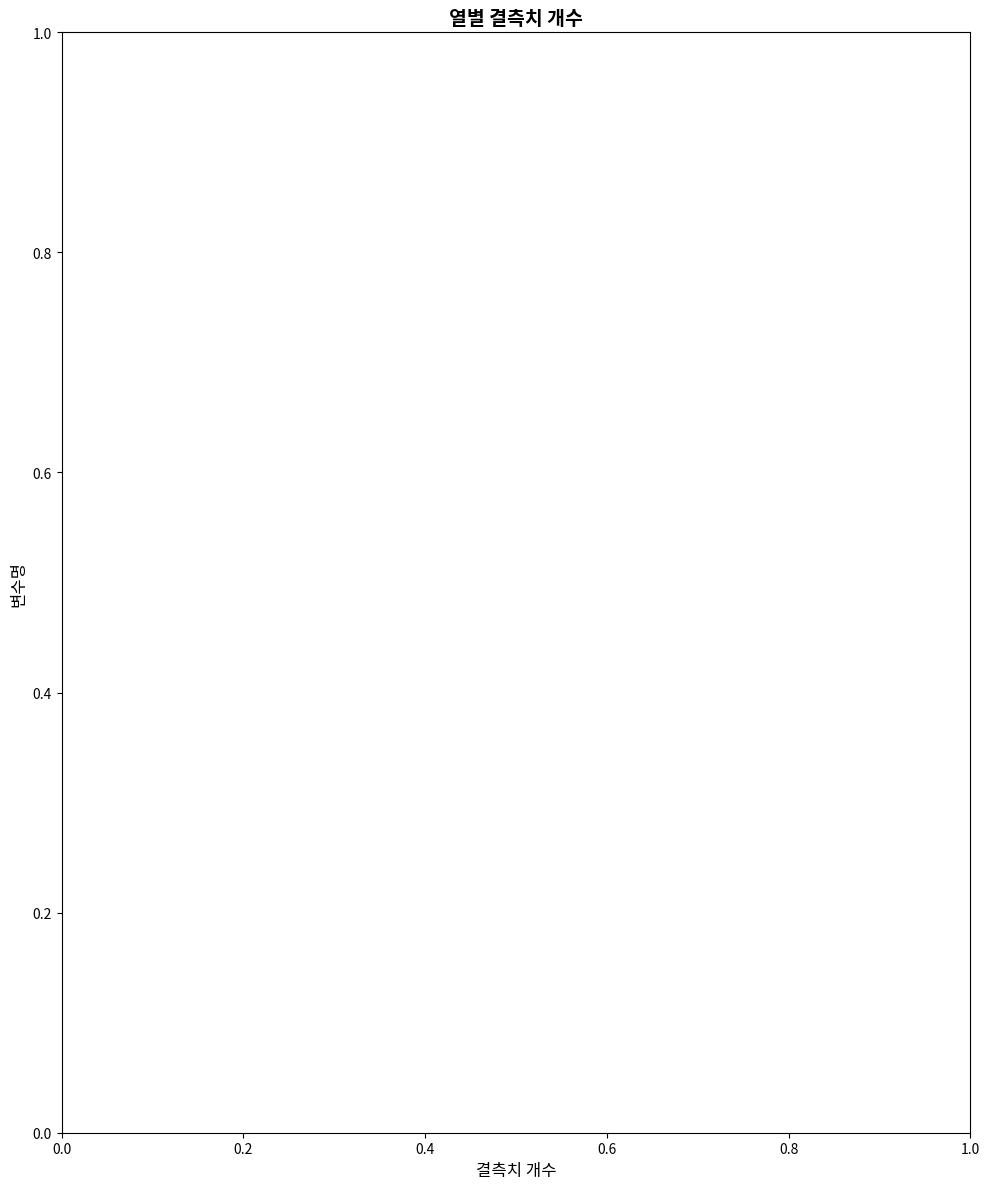

In [12]:
# 1. 열별 결측치 개수 계산
missing_counts = df.isnull().sum()

# 2. 결측치 있는 열만 추림 & 내림차순 정렬
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# 3. Barplot 시각화
plt.figure(figsize=(10, 12))
sns.barplot(x=missing_counts.values, y=missing_counts.index, palette="Blues_r")
plt.xlabel("결측치 개수", fontsize=12)
plt.ylabel("변수명", fontsize=12)
plt.title("열별 결측치 개수", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# 임시 : 카테고리값까지 넣다 보니 나이와 나이 그룹이 같이 들어감, 이것도 제거
# (BMI는 일단 주석으로만 남기기)

In [13]:
# df_EFA = df_EFA.drop(columns=['D3_1_ht', 'D3_2_wt', 'BMI', 'age_group'])
# df_CFA = df_CFA.drop(columns=['D3_1_ht', 'D3_2_wt', 'BMI', 'age_group'])

df_EFA = df_EFA.drop(columns=['age_group'])
df_CFA = df_CFA.drop(columns=['age_group'])

print(df_EFA.shape)

(1181, 95)


# 분산이 작은 변수는 요인분석에 방해됨 : 분산이 1e-5 이하인 변수 제거

In [14]:
var_threshold = 1e-5
low_var_cols = df.var()[df.var() <= var_threshold].index.tolist()
print("[제거] 분산이 너무 작은 열:", low_var_cols)

df = df.drop(columns=low_var_cols)
df_EFA = df_EFA.drop(columns=low_var_cols)
df_CFA = df_CFA.drop(columns=low_var_cols)


[제거] 분산이 너무 작은 열: []


# EFA 시작

### 하기 전에 범주별로 나누고 KMO, Bartlett으로 EFA 해도 되는 수준인지 먼저 확인 필요

## ver4 추가 : threshold 기준 변수인 경우 조사에서 우선 제외

In [15]:
# ==== 스크리 플롯 전용: 요인 수 가늠 ==== ** 카테고리 값은 EFA에 넣어봤자 의미 없으니 제외, 결측치 0으로 채울 시 전부 없어서 평균이 0인 경우의 열도 제외, 셋 중 하나만 살릴 것 **
                                                                                    # 결측치를 전부 제거한 경우에도 일단은 돌려둠 : 어차피 분산이 0인 경우도 제외해야 하므로



# ==== Socio-demographic ====
fa_vars_soc = [c for c in [
"SW",    # 교대근무자 (shift worker)
"sex",    # 성별
"age",    # 나이 (설문기준)
"Q59_1_w",    # 일주일 중 근무하는 날 횟수
"Q59_1_f",    # 일주일 중 쉬는 날 횟수
"D3_1_ht",    # 키
"D3_2_wt",    # 몸무게
"BMI",    # 체질량지수
"D4_edu",    # 학력수준
"D5_income",    # 수입수준
"Q56_alc",    # 음주상태
"Q57_smok",    # 흡연상태
"Q58_exercise",    # 몸에서 땀이 날 정도의 운동상태
] if c in df.columns]


# ==== 수면기회 (Opportunity) ====

fa_vars_opp = [c for c in [
"MCTQ_BTw_c",    # 근무날 침대로 들어가는 시각
"MCTQ_BTf_c",    # 쉬는날 침대로 들어가는 시각
"MCTQ_BTa_c",    # 평균 침대로 들어가는 시각
"MCTQ_GUw",    # 근무날 침대에서 나오는 시각
"MCTQ_GUf",    # 쉬는날 침대에서 나오는 시각
"MCTQ_GUa",    # 평균 침대에서 나오는 시각
"MCTQ_MBW",    # 근무날 침대에 있는 시각 중간점
"MCTQ_MBF",    # 쉬는날 침대에 있는 시각 중간점
"MCTQ_Sprepw_c",    # 근무날 잠 잘 준비가 된 시각
"MCTQ_Sprepf_c",    # 쉬는날 잠 잘 준비가 된 시각
"MCTQ_Sprepa_c",    # 평균 잠 잘 준비가 된 시간
"MCTQ_TBTw_c",    # 근무날 침대에 있는 시간
"MCTQ_TBTf_c",    # 쉬는날 침대에 있는 시간
"MCTQ_TBTa_c",    # 평균 침대에 있는 시간
"MCTQ_TFSw",    # 근무날 수면을 위한 시간
"MCTQ_TFSf",    # 쉬는날 수면을 위한 시간
"MCTQ_TFSa",    # 평균 수면을 위한 시간
"MCTQ_TFPw",    # 근무날 취침 전 지연행동 시간
"MCTQ_TFPf",    # 쉬는날 취침 전 지연행동 시간
"MCTQ_TFPa",    # 평균 취침 전 지연행동 시간
"Q64_SIw",    # 근무날 기상 후 지연행동 시간
"Q74_SIf",    # 쉬는날 기상 후 지연행동 시간
"MCTQ_SIa",    # 평균 기상 후 지연행동 시간
"MCTQ_SJL_bed",    # 근무날/쉬는날 침대에 있는 시간 중간점 차이
"MCTQ_bed_reg",    # 근무날/쉬는날 침대에 있는 시간의 상대적 차이
] if c in df.columns]



# ==== 수면능력 (Ability) ====

fa_vars_abi = [c for c in [
"MCTQ_SDw_c",    # 근무날 수면시간
"MCTQ_SDf_c",    # 쉬는날 수면시간
"MCTQ_SDa_c",    # 평균 수면시간
"Q62_SLatw",    # 근무날 수면잠복기
"Q72_SLatf",    # 쉬는날 수면잠복기
"MCTQ_Slata",    # 평균 수면잠복기
"MCTQ_SE_w_c",    # 근무날 수면효율
"MCTQ_SE_f_c",    # 쉬는날 수면효율
"MCTQ_SE_a_c",    # 평균 수면효율
"MCTQ_SOw_c",    # 근무날 잠드는 시각
"MCTQ_SOf_c",    # 쉬는날 잠드는 시각
"MCTQ_SOa_c",    # 평균 잠드는 시각
"MCTQ_SEw",    # 근무날 잠에서 깬 시각
"MCTQ_SEf",    # 쉬는날 잠에서 깬 시각
"MCTQ_SEa",    # 평균 잠에서 깬 시각
"MCTQ_MSW",    # 근무날 수면시각 중간점
"MCTQ_MSF",    # 쉬는날 수면시각 중간점
"MCTQ_SJL",    # 근무날/쉬는날 수면시간 중간점 차이
"MCTQ_sleep_reg",    # 근무날/쉬는날 수면시간의 상대적 차이
"Q88_snor",    # 코골이 여부
"Q89_apnea",    # 무호흡 여부
"Q82_PSQI_med",    # 수면제 복용 경험
"ISI_sum",    # 불면증 심각도 척도 (ISI)
# "insomnia",    # 불면증 심각도 척도 10점 이상
"PSQI_sum_WA",    # 피처버그 수면의 질 지수 (PSQI)
# "poor_sleeper",    # 피처버그 수면의 질 지수 5점 초과
] if c in df.columns]



# ==== 수면필요 (Need) ====

fa_vars_nee = [c for c in [
"Q51_slp_sufficient",    # 야간수면 충분도
"Q91_ISI_4",    # 수면양상 만족도
"MCTQ_CUS",    # 주말 수면 보충 시간
"desired_sd_min",    # 충분하다고 생각하는 수면 시간
"Pristine_SD",    # Pristine 평가 수면시간
"SD_mismatch_desired",    # 충분수면시간과 실제 차이
"SD_mismatch_pristine",    # Pristine 평가 수면시간과 실제 차이
"nap_n",    # 낮잠횟수
"Q48_nap_dur",    # 낮잠시간
"ESS_sum",    # 앱워스 졸음척도 (ESS)
# "EDS",    # 앱워스 졸음척도 10점 초과
"inertia",    # 수면관성 (기상 후 머리가 맑아질때까지 시간)
"FSS_sum",    # 피로 증상 척도 (FSS)
# "fatigue",    # 피로 증상 척도 36점 이상
"Pristine_SO_c",    # Pristine 평가 잠드는 시각
"Pristine_SE",    # Pristine 평가 잠에서 깬 시각
"Pristine_MS",    # Pristine 평가 수면시각 중간점
"SO_mismatch_pristine",    # Pristine 평가 잠드는 시각과 실제 차이
"SE_mismatch_pristine",    # Pristine 평가 잠에서 깬 시각과 실제 차이
"MSW_mismatch_pristine",    # Pristine 평가 수면시각 중간점과 실제 차이
"MSF_mismatch_pristine",    # Pristine 평가 잠드는 시각과 실제 잠드는 시각 차이
"MCTQ_MSFsc",    # 일주기유형
] if c in df.columns]



# ==== Other ====
fa_vars_oth = [c for c in [
"GAD_sum",    # 범불안장애 7문항 척도 (GAD-7)
# "anxiety",    # 범불안장애 7문항 척도 10점 이상
"PHQ_sum",    # 우울증 건강설문 9문항 (PHQ-9)
# "depression",    # 우울증 건강설문 9문항 10점 이상
"MCFSI_sum",    # 우편 인지기능 설문지 (MCFSI)
# "poor_cog",    # 우편 인지기능 설문지 (MCFSI) 5점 초과
"D1_1_HT",    # 고혈압
"D1_2_DM",    # 당뇨
"D1_3_HLP",    # 고지혈증
] if c in df.columns]



# 범주별 변수 목록 (자동화용)
fa_blocks = {
    "soc": fa_vars_soc,
    "opp": fa_vars_opp,
    "abi": fa_vars_abi,
    "nee": fa_vars_nee,
    "oth": fa_vars_oth,
}


# # ==== 전체 값 (Ver 2에선 카테고리 값도 그냥 EFA 분석에 추가하기, 대신 EFA용 부분 데이터셋만 사용) ====
# fa_vars_all = df_EFA.columns.tolist() # 데이터프레임이 아니라 변수명이 들어가야 함
fa_vars_all = [var for var_list in fa_blocks.values() for var in var_list] # 위에서 살린 변수만 넣는 로직

# Ver 4 추가 : 수작업 변형 진행 (전체 변수 대상으로 하는 경우 이 부분 넘기기!)

In [16]:
# ==== Socio-demographic ====
fa_vars_soc = [c for c in [
"SW",    # 교대근무자 (shift worker)
"sex",    # 성별
"age",    # 나이 (설문기준)
"D3_1_ht",    # 키
"D3_2_wt",    # 몸무게
"D4_edu",    # 학력수준
"D5_income",    # 수입수준
"Q56_alc",    # 음주상태
"Q57_smok",    # 흡연상태
"Q58_exercise",    # 몸에서 땀이 날 정도의 운동상태
] if c in df.columns]


# ==== 수면기회 (Opportunity) ====

fa_vars_opp = [c for c in [
"MCTQ_BTw_c",    # 근무날 침대로 들어가는 시각
"MCTQ_BTf_c",    # 쉬는날 침대로 들어가는 시각
"MCTQ_BTa_c",    # 평균 침대로 들어가는 시각
"MCTQ_GUw",    # 근무날 침대에서 나오는 시각
"MCTQ_GUa",    # 평균 침대에서 나오는 시각
"MCTQ_Sprepw_c",    # 근무날 잠 잘 준비가 된 시각
"MCTQ_Sprepf_c",    # 쉬는날 잠 잘 준비가 된 시각
"MCTQ_Sprepa_c",    # 평균 잠 잘 준비가 된 시간
"MCTQ_SIa",    # 평균 기상 후 지연행동 시간
"MCTQ_SJL_bed",    # 근무날/쉬는날 침대에 있는 시간 중간점 차이
"MCTQ_bed_reg",    # 근무날/쉬는날 침대에 있는 시간의 상대적 차이
] if c in df.columns]



# ==== 수면능력 (Ability) ====

fa_vars_abi = [c for c in [
"MCTQ_SE_w_c",    # 근무날 수면효율
"MCTQ_SE_f_c",    # 쉬는날 수면효율
"MCTQ_SE_a_c",    # 평균 수면효율
"MCTQ_SOw_c",    # 근무날 잠드는 시각
"MCTQ_SOf_c",    # 쉬는날 잠드는 시각
"MCTQ_SOa_c",    # 평균 잠드는 시각
"MCTQ_SEf",    # 쉬는날 잠에서 깬 시각
"MCTQ_SEa",    # 평균 잠에서 깬 시각
"MCTQ_SJL",    # 근무날/쉬는날 수면시간 중간점 차이
"MCTQ_sleep_reg",    # 근무날/쉬는날 수면시간의 상대적 차이
"Q89_apnea",    # 무호흡 여부
] if c in df.columns]


# ==== 수면필요 (Need) ====

fa_vars_nee = [c for c in [
"Q51_slp_sufficient",    # 야간수면 충분도
"Q91_ISI_4",    # 수면양상 만족도
"MCTQ_CUS",    # 주말 수면 보충 시간
"nap_n",    # 낮잠횟수
"ESS_sum",    # 앱워스 졸음척도 (ESS)
"inertia",    # 수면관성 (기상 후 머리가 맑아질때까지 시간)
"Pristine_SO_c",    # Pristine 평가 잠드는 시각
"Pristine_SE",    # Pristine 평가 잠에서 깬 시각
"Pristine_MS",    # Pristine 평가 수면시각 중간점
"SO_mismatch_pristine",    # Pristine 평가 잠드는 시각과 실제 차이
"SE_mismatch_pristine",    # Pristine 평가 잠에서 깬 시각과 실제 차이
"MCTQ_MSFsc",    # 일주기유형
] if c in df.columns]

# ==== Other ====
fa_vars_oth = [c for c in [
"GAD_sum",    # 범불안장애 7문항 척도 (GAD-7)
"PHQ_sum",    # 우울증 건강설문 9문항 (PHQ-9)
"MCFSI_sum",    # 우편 인지기능 설문지 (MCFSI)
"D1_1_HT",    # 고혈압
"D1_2_DM",    # 당뇨
"D1_3_HLP",    # 고지혈증
] if c in df.columns]



# 범주별 변수 목록 (자동화용)
fa_blocks = {
    "soc": fa_vars_soc,
    "opp": fa_vars_opp,
    "abi": fa_vars_abi,
    "nee": fa_vars_nee,
    "oth": fa_vars_oth,
}

# # ==== fa_blocks에 포함된 모든 변수를 하나의 리스트로 통합 ====
fa_vars_all = [var for var_list in fa_blocks.values() for var in var_list]

# Ver 3 추가 : KMO, Bartlett 검증 (하나짜리)

In [17]:
# 나눠진 범주들의 EFA 적합도 확인(KMO, Bartlett)
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

# 1) 분석에 쓸 변수만 추출 -> 여기서 fa_vars_ 선택할 것!!!! ###################
df_fa = df_EFA[fa_vars_all].copy()

# 2) 결측치 처리 (여기선 간단히 행 단위로 드롭)
#    실제론 평균대체 / MICE / domain-specific imputing 고려해도 됨
# df_fa = df_fa.dropna() # 이미 위에서 수행했음

# 3) KMO 계산
kmo_all, kmo_model = calculate_kmo(df_fa)
print("KMO (overall):", round(kmo_model, 3))

# 변수별 KMO가 궁금하면:
kmo_by_var = dict(zip(df_fa.columns, kmo_all))
print("KMO by variable:")
for col, val in kmo_by_var.items():
    print(f"  {col}: {val:.3f}")

# 4) Bartlett 구형성 검정
chi_square, p_value = calculate_bartlett_sphericity(df_fa)
print("Bartlett's test chi-square:", round(chi_square, 3))
print("Bartlett's test p-value:", p_value)


KMO (overall): 0.839
KMO by variable:
  SW: 0.592
  sex: 0.765
  age: 0.930
  D3_1_ht: 0.825
  D3_2_wt: 0.828
  D4_edu: 0.917
  D5_income: 0.920
  Q56_alc: 0.881
  Q57_smok: 0.821
  Q58_exercise: 0.544
  MCTQ_BTw_c: 0.878
  MCTQ_BTf_c: 0.942
  MCTQ_BTa_c: 0.879
  MCTQ_GUw: 0.925
  MCTQ_GUa: 0.750
  MCTQ_Sprepw_c: 0.908
  MCTQ_Sprepf_c: 0.891
  MCTQ_Sprepa_c: 0.902
  MCTQ_SIa: 0.370
  MCTQ_SJL_bed: 0.800
  MCTQ_bed_reg: 0.802
  MCTQ_SE_w_c: 0.638
  MCTQ_SE_f_c: 0.577
  MCTQ_SE_a_c: 0.635
  MCTQ_SOw_c: 0.901
  MCTQ_SOf_c: 0.912
  MCTQ_SOa_c: 0.901
  MCTQ_SEf: 0.929
  MCTQ_SEa: 0.747
  MCTQ_SJL: 0.787
  MCTQ_sleep_reg: 0.829
  Q89_apnea: 0.356
  Q51_slp_sufficient: 0.894
  Q91_ISI_4: 0.866
  MCTQ_CUS: 0.882
  nap_n: 0.880
  ESS_sum: 0.824
  inertia: 0.887
  Pristine_SO_c: 0.917
  Pristine_SE: 0.818
  Pristine_MS: 0.907
  SO_mismatch_pristine: 0.854
  SE_mismatch_pristine: 0.665
  MCTQ_MSFsc: 0.913
  GAD_sum: 0.712
  PHQ_sum: 0.722
  MCFSI_sum: 0.916
  D1_1_HT: 0.908
  D1_2_DM: 0.913
  D1_

/home/hschoi/.conda/envs/sleephi/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


# Ver 3 추가 : KMO 결과 값이 threshold 미만인 변수 쳐내기, 범주별 df 모두에 대해 동작

In [18]:
from factor_analyzer.factor_analyzer import calculate_kmo

# EFA 전처리 가져옴
def preprocess_for_fa(df, fa_vars, min_var=1e-12):
    """EFA용 전처리: 숫자화→Inf/NaN 처리→전부 결측 열 제거→중앙값 대치→분산≈0 열 제거"""
    X = df[fa_vars].copy()
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan)

    # 전부 결측 열 제거
    all_nan_cols = X.columns[X.isna().all()]
    if len(all_nan_cols) > 0:
        X = X.drop(columns=all_nan_cols)

    # 중앙값 대치
    imp = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

    # 분산≈0 열 제거
    stds = X_imp.std(ddof=0)
    keep = stds > min_var
    X_imp = X_imp.loc[:, keep]

    # 남은 열이 최소 3개 미만이면 EFA 불가
    if X_imp.shape[1] < 3:
        raise ValueError(f"[중단] 정제 후 변수 수 부족: {list(X_imp.columns)}")

    return X_imp

def drop_low_kmo_vars(df: pd.DataFrame,
                      kmo_thr: float = 0.50,
                      verbose: bool = True):
    """
    개별 KMO가 kmo_thr보다 작은 변수들을 제거.
    df는 이미 숫자화/결측대치/분산제거가 끝난 상태여야 함.
    """
    kmo_all, kmo_model = calculate_kmo(df)
    kmo_by_var = dict(zip(df.columns, kmo_all))

    removed_vars = [col for col, val in kmo_by_var.items() if val < kmo_thr]
    kept_vars    = [col for col in df.columns if col not in removed_vars]

    if verbose:
        print(f"  - KMO overall: {kmo_model:.3f}")
        print(f"  - threshold : {kmo_thr}")
        if removed_vars:
            print("  - removed by KMO:")
            for rv in removed_vars:
                print(f"      {rv}: {kmo_by_var[rv]:.3f}")
        else:
            print("  - removed by KMO: (none)")

    return df[kept_vars].copy(), removed_vars, kmo_by_var, kmo_model



###### 임계값 ###########
###### 0으로 지정하면 KMO 필터링 안 함 ################
kmo_thr = 0

###### 임시 : 전체 데이터 대상으로 KMO 수행하기 ################
# kmo_blocks = fa_blocks
kmo_blocks = {"all":fa_vars_all} # 전체 대상 지정(야매)



# 결과 담을 그릇
kmo_filtered_blocks = {}     # prefix → (정제된 df)
kmo_removed_vars = {}        # prefix → [제거된 변수들]
kmo_by_var_all = {}          # prefix → {var: kmo}
kmo_overall_all = {}         # prefix → overall kmo

for prefix, var_list in kmo_blocks.items():
    print(f"\n[{prefix}] KMO filtering start...")

    # 1) 일단 수치화/결측대치/분산≈0 제거
    try:
        X_imp = preprocess_for_fa(df_EFA, var_list)
    except ValueError as e:
        # 변수 3개 미만 등으로 preprocess 단계에서 막히는 케이스
        print(f"  ! skipped: {e}")
        continue

    # 2) KMO 기준으로 변수 떨구기
    X_kmo, removed_vars, kmo_by_var, kmo_overall = drop_low_kmo_vars(
        X_imp,
        kmo_thr=kmo_thr,
        verbose=True
    )

    # 3) 변수 3개 미만이면 이 범주는 EFA 안 돌리는 게 낫다
    if X_kmo.shape[1] < 3:
        print(f"  ! after KMO filtering, vars={X_kmo.shape[1]} < 3 → skip EFA for [{prefix}]")
    else:
        print(f"  - kept vars ({X_kmo.shape[1]}): {list(X_kmo.columns)}")

    # 4) 결과 저장
    kmo_filtered_blocks[prefix] = X_kmo
    kmo_removed_vars[prefix] = removed_vars
    kmo_by_var_all[prefix] = kmo_by_var
    kmo_overall_all[prefix] = kmo_overall

print("\n=== KMO filtering summary ===")
for prefix in kmo_blocks.keys():
    if prefix not in kmo_filtered_blocks:
        continue
    print(f"- {prefix}: overall KMO={kmo_overall_all[prefix]:.3f}, "
          f"kept={kmo_filtered_blocks[prefix].shape[1]}, "
          f"removed={len(kmo_removed_vars[prefix])}")



[all] KMO filtering start...
  - KMO overall: 0.839
  - threshold : 0
  - removed by KMO: (none)
  - kept vars (50): ['SW', 'sex', 'age', 'D3_1_ht', 'D3_2_wt', 'D4_edu', 'D5_income', 'Q56_alc', 'Q57_smok', 'Q58_exercise', 'MCTQ_BTw_c', 'MCTQ_BTf_c', 'MCTQ_BTa_c', 'MCTQ_GUw', 'MCTQ_GUa', 'MCTQ_Sprepw_c', 'MCTQ_Sprepf_c', 'MCTQ_Sprepa_c', 'MCTQ_SIa', 'MCTQ_SJL_bed', 'MCTQ_bed_reg', 'MCTQ_SE_w_c', 'MCTQ_SE_f_c', 'MCTQ_SE_a_c', 'MCTQ_SOw_c', 'MCTQ_SOf_c', 'MCTQ_SOa_c', 'MCTQ_SEf', 'MCTQ_SEa', 'MCTQ_SJL', 'MCTQ_sleep_reg', 'Q89_apnea', 'Q51_slp_sufficient', 'Q91_ISI_4', 'MCTQ_CUS', 'nap_n', 'ESS_sum', 'inertia', 'Pristine_SO_c', 'Pristine_SE', 'Pristine_MS', 'SO_mismatch_pristine', 'SE_mismatch_pristine', 'MCTQ_MSFsc', 'GAD_sum', 'PHQ_sum', 'MCFSI_sum', 'D1_1_HT', 'D1_2_DM', 'D1_3_HLP']

=== KMO filtering summary ===
- all: overall KMO=0.839, kept=50, removed=0


/home/hschoi/.conda/envs/sleephi/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


# Ver 3 추가 : 제거된 변수 목록 확인

In [19]:
kmo_filtered_blocks

{'all':             SW       sex       age   D3_1_ht   D3_2_wt    D4_edu  D5_income  \
 1231  0.198986 -1.006368  1.337831  1.462181  1.233204 -0.223537  -0.384997   
 353   0.198986 -1.006368 -1.110128  1.096842  0.576303  0.919794   0.850515   
 606   0.198986 -1.006368 -0.192144  1.218622  1.327047  0.919794   0.026840   
 1150  0.198986 -1.006368  1.888621  0.609723  0.013244 -1.366868  -0.384997   
 1722  0.198986  0.993672 -0.375740 -0.364515 -0.643657  0.919794   1.262352   
 ...        ...       ...       ...       ...       ...       ...        ...   
 1738  0.198986  0.993672 -0.008547 -1.216973 -1.300558 -0.223537   0.438677   
 1159  0.198986 -1.006368  1.766223  0.487944  0.388617 -0.223537  -0.796835   
 1196  0.198986 -1.006368  2.072218  2.192860  0.107087 -1.366868  -2.032347   
 1371  0.198986  0.993672 -1.477322 -0.729854 -0.925186  0.919794   1.262352   
 918   0.198986 -1.006368  0.052652 -0.486294  0.670146 -0.223537   0.026840   
 
        Q56_alc  Q57_smok  Q58_

## After KMO : 제거된 후 KMO값 다시 한 번 뽑아보기

In [20]:
# ===============================================================
# 각 범주별 KMO (필터링 후 변수 집합 기준) 다시 계산
# ===============================================================
print("\n=== Recomputed KMO (after filtering) ===")

kmo_after_filter = {}

for prefix, X_kmo in kmo_filtered_blocks.items():
    if X_kmo.shape[1] < 3:
        print(f"[{prefix}] 변수 수 {X_kmo.shape[1]}개 → KMO 계산 생략")
        continue

    kmo_all, kmo_model = calculate_kmo(X_kmo)
    kmo_after_filter[prefix] = {
        'overall': round(kmo_model, 3),
        'by_var': dict(zip(X_kmo.columns, kmo_all))
    }

    print(f"\n[{prefix}]")
    print(f"  - overall KMO: {kmo_model:.3f}")
    for col, val in zip(X_kmo.columns, kmo_all):
        print(f"    {col}: {val:.3f}")

print("\n=== Summary (after KMO filtering) ===")
for prefix, res in kmo_after_filter.items():
    print(f"- {prefix}: overall KMO = {res['overall']:.3f}, "
          f"vars = {len(res['by_var'])}")



=== Recomputed KMO (after filtering) ===

[all]
  - overall KMO: 0.839
    SW: 0.592
    sex: 0.765
    age: 0.930
    D3_1_ht: 0.825
    D3_2_wt: 0.828
    D4_edu: 0.917
    D5_income: 0.920
    Q56_alc: 0.881
    Q57_smok: 0.821
    Q58_exercise: 0.544
    MCTQ_BTw_c: 0.878
    MCTQ_BTf_c: 0.942
    MCTQ_BTa_c: 0.879
    MCTQ_GUw: 0.925
    MCTQ_GUa: 0.750
    MCTQ_Sprepw_c: 0.908
    MCTQ_Sprepf_c: 0.891
    MCTQ_Sprepa_c: 0.902
    MCTQ_SIa: 0.370
    MCTQ_SJL_bed: 0.800
    MCTQ_bed_reg: 0.802
    MCTQ_SE_w_c: 0.638
    MCTQ_SE_f_c: 0.577
    MCTQ_SE_a_c: 0.635
    MCTQ_SOw_c: 0.901
    MCTQ_SOf_c: 0.912
    MCTQ_SOa_c: 0.901
    MCTQ_SEf: 0.929
    MCTQ_SEa: 0.747
    MCTQ_SJL: 0.787
    MCTQ_sleep_reg: 0.829
    Q89_apnea: 0.356
    Q51_slp_sufficient: 0.894
    Q91_ISI_4: 0.866
    MCTQ_CUS: 0.882
    nap_n: 0.880
    ESS_sum: 0.824
    inertia: 0.887
    Pristine_SO_c: 0.917
    Pristine_SE: 0.818
    Pristine_MS: 0.907
    SO_mismatch_pristine: 0.854
    SE_mismatch_pristine

/home/hschoi/.conda/envs/sleephi/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


# 이제 EFA 시작 : 하나에 대해 분석하는 용도
## Scree Plot부터 뽑기

[EFA] 고유값(Eigenvalues): [1.16354e+01 4.52210e+00 3.65560e+00 2.98790e+00 2.63800e+00 2.12590e+00
 1.88990e+00 1.43270e+00 1.31840e+00 1.20520e+00 1.11310e+00 1.07010e+00
 1.01220e+00 9.79300e-01 9.65100e-01 8.82500e-01 8.07600e-01 7.85500e-01
 7.15600e-01 6.99100e-01 6.60400e-01 6.29800e-01 5.75600e-01 5.29600e-01
 5.16400e-01 4.68000e-01 4.45800e-01 4.34500e-01 3.98900e-01 3.62800e-01
 3.31600e-01 3.13800e-01 2.78100e-01 2.70700e-01 2.40200e-01 2.25900e-01
 1.86600e-01 1.52100e-01 1.19900e-01 8.75000e-02 6.86000e-02 6.66000e-02
 5.70000e-02 5.28000e-02 3.91000e-02 1.93000e-02 1.45000e-02 1.12000e-02
 1.80000e-03 0.00000e+00]


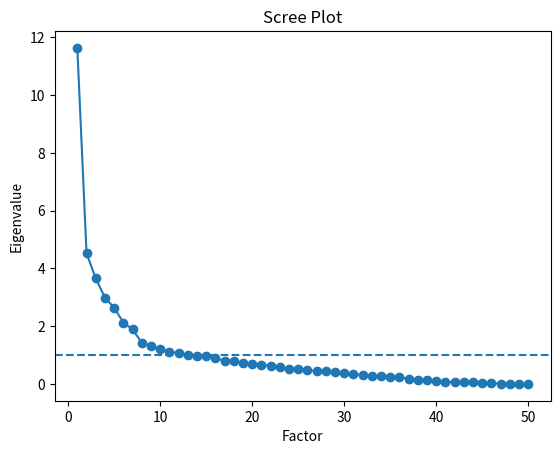

In [21]:
# 변수 선정

fa_vars_kmo_removed_list = {k: list(v.columns) for k, v in kmo_filtered_blocks.items()}

###### 이거 건드리면서 하나씩 EFA할 것 #########################
fa_vars = fa_vars_kmo_removed_list["all"]


if len(fa_vars) < 3:
    raise ValueError(f"[skip] 요인분석 변수 수 부족: {fa_vars}")

# --- 정제 단계 ---
X = df_EFA[fa_vars].copy()
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)

# 1) 전부 결측 열 확인
all_nan_cols = X.columns[X.isna().all()]
if len(all_nan_cols) > 0:
    print("[제거] 전부 결측인 열:", list(all_nan_cols))
X = X.drop(columns=all_nan_cols)

# 2) 중앙값 대치
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

# 3) 분산 0(또는 극소) 열 확인
stds = X_imp.std(ddof=0)
zero_var_cols = stds[stds <= 1e-5].index
if len(zero_var_cols) > 0:
    print("[제거] 분산≈0인 열:", list(zero_var_cols))
X_imp = X_imp.drop(columns=zero_var_cols)

# 4) 상관행렬 NaN 발생 여부 점검
corr = X_imp.corr()
bad_in_corr = corr.columns[corr.isna().any()].tolist()
if len(bad_in_corr) > 0:
    print("[경고] 상관행렬에서 NaN 발생한 열:", bad_in_corr)

# 5) 변수 수 최종 확인
if X_imp.shape[1] < 3:
    raise ValueError(f"[중단] 정제 후 변수 수 부족: {list(X_imp.columns)}")

# --- 스크리 플롯 ---
fa_scree = FactorAnalyzer(rotation='oblimin')
fa_scree.fit(X_imp)

eigenvals, _ = fa_scree.get_eigenvalues()
print("[EFA] 고유값(Eigenvalues):", np.round(eigenvals[:X_imp.shape[1]], 4))

plt.figure()
plt.plot(range(1, len(eigenvals) + 1), eigenvals, marker='o')
plt.axhline(1, linestyle='--')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()


                      Factor1  Factor2  Factor3  Factor4  Factor5  Factor6  Factor7  Factor8
SW                     -0.052   -0.050    0.029   -0.057   -0.031    0.035   -0.048    0.041
sex                     0.106   -0.011   -0.101    0.034    0.074    0.973   -0.170   -0.013
age                     0.076   -0.171    0.037   -0.067   -0.192   -0.021    0.628   -0.029
D3_1_ht                -0.077    0.110    0.041   -0.010   -0.018   -0.853   -0.067    0.037
D3_2_wt                -0.045    0.083    0.063   -0.022   -0.088   -0.793    0.152    0.026
D4_edu                  0.002    0.188   -0.064    0.069    0.162   -0.069   -0.538    0.016
D5_income               0.076    0.177   -0.133    0.058    0.111    0.029   -0.492    0.038
Q56_alc                 0.015    0.023   -0.072   -0.019   -0.149    0.412    0.088   -0.001
Q57_smok                0.082    0.074   -0.067   -0.019   -0.063    0.681   -0.151   -0.048
Q58_exercise           -0.067    0.014    0.070    0.023    0.019    0

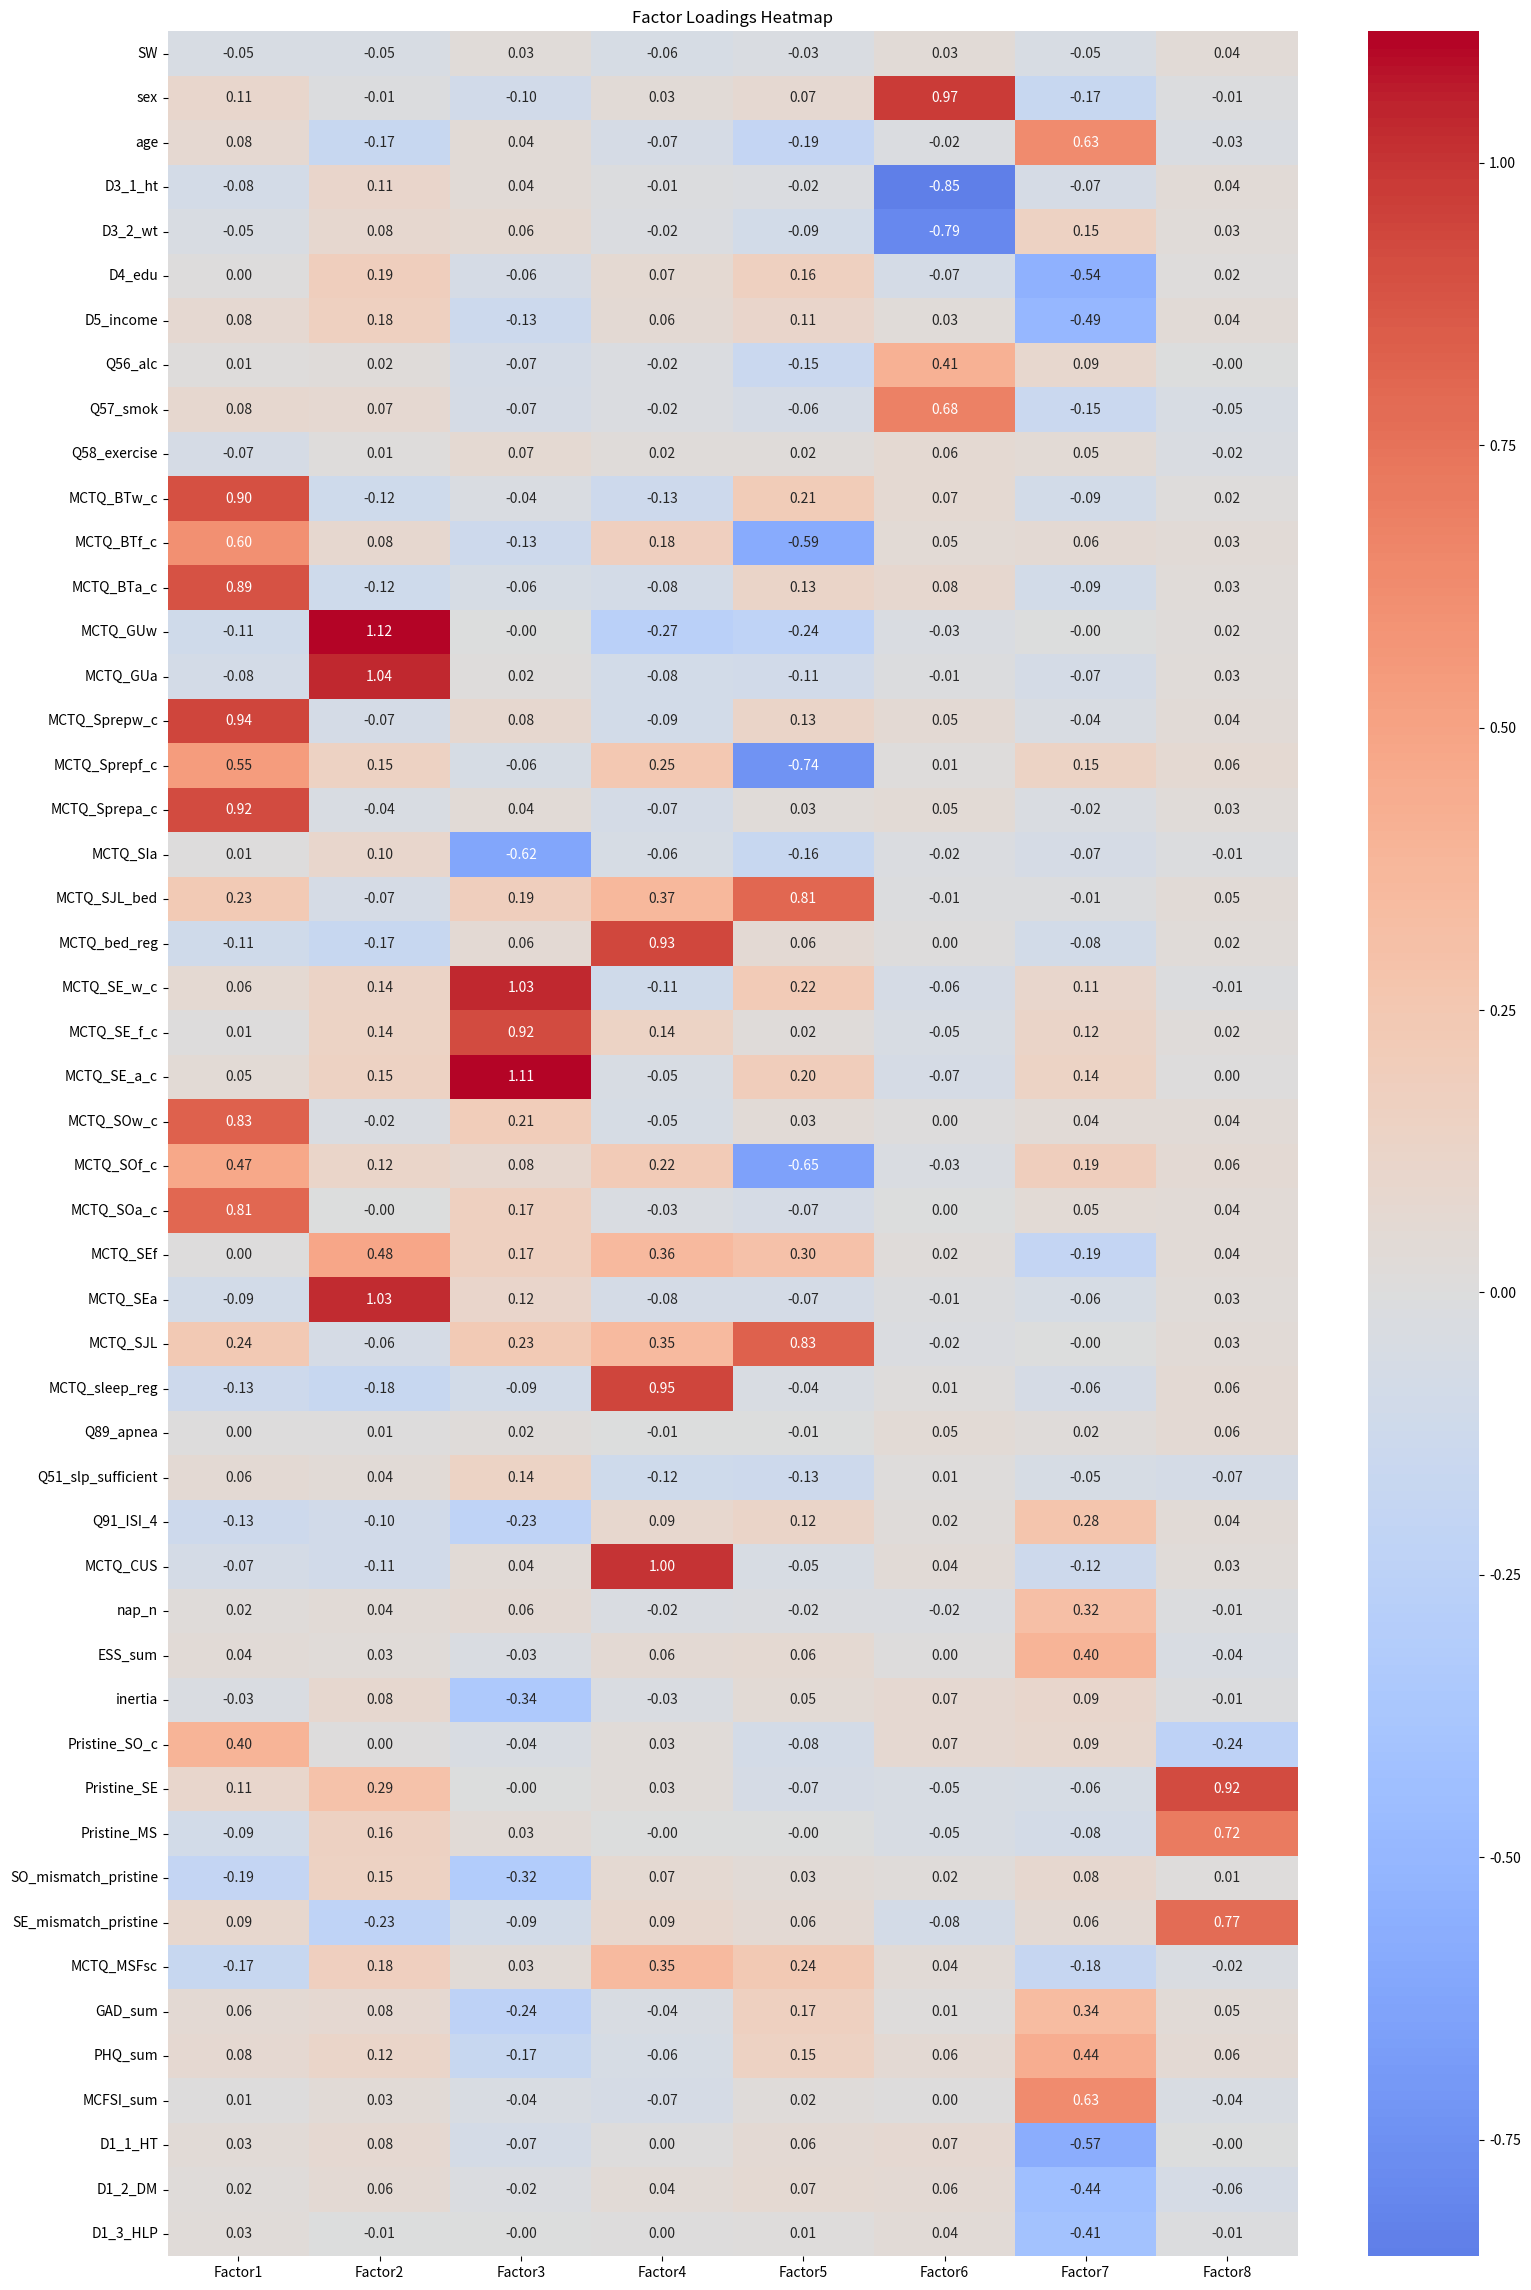

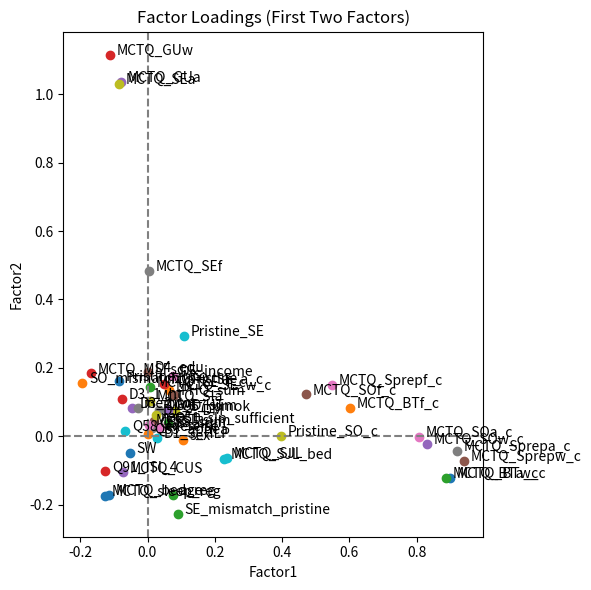

In [22]:
# EFA 시작, 저 밑에 N_FACTORS 설정 후 실행!!!!!

def preprocess_for_fa(df, fa_vars, min_var=1e-12):
    """EFA용 전처리: 숫자화→Inf/NaN 처리→전부 결측 열 제거→중앙값 대치→분산≈0 열 제거"""
    X = df[fa_vars].copy()
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan)

    # 전부 결측 열 제거
    all_nan_cols = X.columns[X.isna().all()]
    if len(all_nan_cols) > 0:
        X = X.drop(columns=all_nan_cols)

    # 중앙값 대치
    imp = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

    # 분산≈0 열 제거
    stds = X_imp.std(ddof=0)
    keep = stds > min_var
    X_imp = X_imp.loc[:, keep]

    # 남은 열이 최소 3개 미만이면 EFA 불가
    if X_imp.shape[1] < 3:
        raise ValueError(f"[중단] 정제 후 변수 수 부족: {list(X_imp.columns)}")

    return X_imp

# ==== 사용자가 선택한 요인 수 ====
N_FACTORS = 8  # <- 스크리 플롯 보고 결정

# fa_vars 는 기존과 동일하게 정의되어 있다고 가정
X_imp = preprocess_for_fa(df_EFA, fa_vars)   # ✅ 스크리플롯과 동일 전처리 적용

# (선택) 표준화: 스케일 차이가 크면 권장
# X_imp = (X_imp - X_imp.mean()) / X_imp.std(ddof=0)

# N_FACTORS 검증: 변수 수를 넘을 수 없음
max_factors = min(X_imp.shape[1]-1, X_imp.shape[0]-1)  # 보수적으로 제한
if N_FACTORS > max_factors:
    raise ValueError(f"N_FACTORS={N_FACTORS}가 허용치({max_factors})를 초과")

# 1-요인일 때 varimax 회전은 의미가 거의 없음(keep 그대로 사용해도 무방)
fa = FactorAnalyzer(n_factors=N_FACTORS, rotation="promax")
fa.fit(X_imp)

# 적재치 행렬
cols = [f"Factor{i+1}" for i in range(N_FACTORS)]
loadings = pd.DataFrame(fa.loadings_, index=X_imp.columns, columns=cols)
print(loadings.round(3).to_string())
loadings.round(3).to_csv("factor_loadings.csv", index=True, encoding="utf-8-sig") # 파일 저장

# # ---- Heatmap (축 개수 제한 없음) ----
# plt.figure(figsize=(1.5*N_FACTORS+4, 0.4*len(loadings)+3))
# sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0, fmt=".2f")
# plt.title("Factor Loadings Heatmap")
# plt.tight_layout()
# plt.show()


# ---- Heatmap (축 개수 제한 없음, 단 변수 많으면 단순화) ----
MAX_ANNOT_VARS = 4000  # 이 값 넘으면 숫자 제거 + 크기 간소화     ===>>> 일단 여기선 전체 경향을 봐야 하므로 그냥 다 표시

n_vars = len(loadings)
annot_flag = n_vars <= MAX_ANNOT_VARS

fig_height = min(0.4 * n_vars + 3, 25)  # 세로축 최대 크기 제한 (예: 25인치)

plt.figure(figsize=(1.5*N_FACTORS+4, fig_height))
sns.heatmap(
    loadings,
    annot=annot_flag,
    cmap="coolwarm",
    center=0,
    fmt=".2f" if annot_flag else "",
    cbar=True
)
plt.title("Factor Loadings Heatmap" + ("" if annot_flag else " (values hidden)"))
plt.tight_layout()
plt.show()



# ---- Loading Scatter: 앞 두 축만 ----
if N_FACTORS >= 2:
    plt.figure(figsize=(6,6))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    for var in loadings.index:
        x, y = loadings.loc[var, "Factor1"], loadings.loc[var, "Factor2"]
        plt.scatter(x, y)
        plt.text(x + 0.02, y, var)
    plt.xlabel("Factor1")
    plt.ylabel("Factor2")
    plt.title("Factor Loadings (First Two Factors)")
    plt.tight_layout()
    plt.show()
else:
    print("[info] N_FACTORS=1: 산점도(2D) 생략")

In [23]:
# 공통성 / 특이성 계산
communalities = pd.Series(fa.get_communalities(), index=X_imp.columns, name="Communality")
uniqueness    = pd.Series(fa.get_uniquenesses(), index=X_imp.columns, name="Uniqueness")

result = pd.concat([communalities, uniqueness], axis=1).round(3)
print(result.to_string())
result.to_csv("communality.csv", index=True, encoding="utf-8-sig") # 파일 저장


                      Communality  Uniqueness
SW                          0.015       0.985
sex                         1.003      -0.003
age                         0.474       0.526
D3_1_ht                     0.754       0.246
D3_2_wt                     0.674       0.326
D4_edu                      0.365       0.635
D5_income                   0.315       0.685
Q56_alc                     0.206       0.794
Q57_smok                    0.510       0.490
Q58_exercise                0.017       0.983
MCTQ_BTw_c                  0.899       0.101
MCTQ_BTf_c                  0.770       0.230
MCTQ_BTa_c                  0.843       0.157
MCTQ_GUw                    1.387      -0.387
MCTQ_GUa                    1.106      -0.106
MCTQ_Sprepw_c               0.927       0.073
MCTQ_Sprepf_c               0.955       0.045
MCTQ_Sprepa_c               0.858       0.142
MCTQ_SIa                    0.426       0.574
MCTQ_SJL_bed                0.883       0.117
MCTQ_bed_reg                0.929 

# Ver 2 추가 : CFA를 위한 요인구조 정제 전처리
# Ver 3 변경 필요 : 위에서 계층적으로 형성한 데이터 기반으로 수정 내지 추가 정제하는 코드로 변경해야 함
- 공통성이 특정 값 이하인 변수 제거 (기본 : 0.2)
- 가장 높은 적재량(절대값)이 특정 값 이하인 변수 제거 (기본 : 0.35)
- 적재량이 가장 높은 요인으로 구조화

In [24]:
from itertools import zip_longest
import pandas as pd

def refine_for_cfa(
    result,
    loadings,
    n_factors,
    communality_thr=0.5,
    loading_thr=0.5,
    cross_loading_thr=0.2  # 1순위와 2순위 loading 차이 기준
    ### 여기 값들은 기본설정 값이므로 직접 지정하는건 밑에서 할 것!
):
    df_comm = result.copy()
    df_load = loadings.copy()

    # 1️⃣ 공통성 기준
    drop_comm = df_comm[df_comm["Communality"] <= communality_thr].index.tolist()

    # 2️⃣ 최대 적재량 기준
    abs_all = df_load.abs()
    max_load = abs_all.max(axis=1)
    drop_low = max_load[max_load <= loading_thr].index.tolist()

    # 3️⃣ 1차 제거 대상 (공통성 + 최대 적재량)
    base_drop_vars = set(drop_comm + drop_low)
    print(f"[제거] 공통성≤{communality_thr} 또는 최대적재량≤{loading_thr} 변수 {len(base_drop_vars)}개:")
    print(base_drop_vars, "\n")

    # 4️⃣ 1차 필터링 후 데이터프레임
    keep_vars = [v for v in df_load.index if v not in base_drop_vars]
    abs_load = abs_all.loc[keep_vars]

    # 5️⃣ 요인별 변수 구조화 + cross-loading 처리
    factor_map = {f"Factor{i}": [] for i in range(1, n_factors + 1)}
    drop_cross = []  # cross-loading 기준 미만으로 제거된 변수들

    for var in keep_vars:
        row = abs_load.loc[var]

        # loading_thr 이상인 요인들만 "강한 적재"로 간주
        strong_mask = row >= loading_thr
        strong_factors = row.index[strong_mask].tolist()

        # 강하게 적재된 요인이 없으면 (이론상 drop_low에서 이미 제거되었으므로 거의 안 나올 것)
        if len(strong_factors) == 0:
            continue

        # ① 단일 요인에만 강하게 적재 → 그대로 그 요인에 배정
        if len(strong_factors) == 1:
            factor_map[strong_factors[0]].append(var)

        # ② 둘 이상의 요인에 강하게 적재된 경우 (cross-loading)
        else:
            # strong_factors 중에서만 정렬 (loading 내림차순)
            sorted_strong = row[strong_factors].sort_values(ascending=False)
            top1_factor, top1_val = sorted_strong.index[0], sorted_strong.iloc[0]
            top2_val = sorted_strong.iloc[1]  # 2순위 값

            diff = top1_val - top2_val

            # 차이가 cross_loading_thr 이상이면 → 1순위 요인에만 배정
            if diff >= cross_loading_thr:
                factor_map[top1_factor].append(var)
            else:
                # 어떤 요인에도 배정하지 않고 CFA에서 제거
                drop_cross.append(var)

    # 6️⃣ 최종 제거 변수 집합
    drop_vars = sorted(base_drop_vars | set(drop_cross))

    print(f"[제거] 교차적재(cross-loading) 기준 미만(Δ<{cross_loading_thr})으로 제거된 변수 {len(drop_cross)}개:")
    if drop_cross:
        print(drop_cross)
    print()

    print(f"✅ 요인별 변수 구조 (cross_loading_thr={cross_loading_thr}, loading_thr={loading_thr})")
    for fname, members in factor_map.items():
        print(f" - {fname} ({len(members)}개): {members}")

    # 7️⃣ 최종 loadings_filtered (모든 drop_vars 제거 후)
    df_load_filtered = df_load.drop(index=drop_vars)

    # 8️⃣ 가로형 CSV 저장
    factor_names = [f"Factor{i}" for i in range(1, n_factors + 1)]
    factor_lists = [factor_map[f] for f in factor_names]
    df_factors_wide = pd.DataFrame(zip_longest(*factor_lists), columns=factor_names)
    df_factors_wide.to_csv("factor_assignment_wide.csv", index=False, encoding="utf-8-sig")
    print("💾 'factor_assignment_wide.csv' (가로형) 파일로 저장 완료.\n")

    return {
        "loadings_filtered": df_load_filtered,
        "drop_vars": drop_vars,
        "factor_groups": factor_map
    }

cfa_refined = refine_for_cfa(
    result=result,
    loadings=loadings,
    n_factors=N_FACTORS, # 위에서 설정된 값으로 진행
    communality_thr=0.5,
    loading_thr=0.7,
    cross_loading_thr=0.2  # 1위 요인과 2위 요인 loading 차이 기준
)


[제거] 공통성≤0.5 또는 최대적재량≤0.7 변수 26개:
{'D1_1_HT', 'ESS_sum', 'D5_income', 'Q89_apnea', 'Q56_alc', 'Q91_ISI_4', 'MCTQ_SIa', 'D1_3_HLP', 'D4_edu', 'SW', 'Q51_slp_sufficient', 'MCTQ_SEf', 'Q58_exercise', 'nap_n', 'inertia', 'Q57_smok', 'MCTQ_SOf_c', 'MCTQ_BTf_c', 'MCTQ_MSFsc', 'SO_mismatch_pristine', 'PHQ_sum', 'D1_2_DM', 'GAD_sum', 'MCFSI_sum', 'Pristine_SO_c', 'age'} 

[제거] 교차적재(cross-loading) 기준 미만(Δ<0.2)으로 제거된 변수 0개:

✅ 요인별 변수 구조 (cross_loading_thr=0.2, loading_thr=0.7)
 - Factor1 (6개): ['MCTQ_BTw_c', 'MCTQ_BTa_c', 'MCTQ_Sprepw_c', 'MCTQ_Sprepa_c', 'MCTQ_SOw_c', 'MCTQ_SOa_c']
 - Factor2 (3개): ['MCTQ_GUw', 'MCTQ_GUa', 'MCTQ_SEa']
 - Factor3 (3개): ['MCTQ_SE_w_c', 'MCTQ_SE_f_c', 'MCTQ_SE_a_c']
 - Factor4 (3개): ['MCTQ_bed_reg', 'MCTQ_sleep_reg', 'MCTQ_CUS']
 - Factor5 (3개): ['MCTQ_Sprepf_c', 'MCTQ_SJL_bed', 'MCTQ_SJL']
 - Factor6 (3개): ['sex', 'D3_1_ht', 'D3_2_wt']
 - Factor7 (0개): []
 - Factor8 (3개): ['Pristine_SE', 'Pristine_MS', 'SE_mismatch_pristine']
💾 'factor_assignment_wide.csv' (가로형) 

In [25]:
# ----------------------------------------
# CFA 구조식(desc) 자동 생성 (+ 요인분산=1 고정 포함)
# ----------------------------------------
def make_cfa_description(factor_map):
    """
    factor_map: {'Factor1': ['a','b'], 'Factor2': ['c','d']} 형태
    반환: lavaan-style formula string
    """
    lines = []
    
    # (1) 요인 적재식 생성
    for factor, vars_ in factor_map.items():
        if len(vars_) == 0:
            continue
        joined = " + ".join(vars_)
        line = f"{factor} =~ {joined}"
        lines.append(line)
    
    # (2) 요인분산=1 고정 구문 자동 추가
    for factor in factor_map.keys():
        lines.append(f"{factor} ~~ 1*{factor}")
    
    # (3) 하나의 문자열로 결합
    desc = "\n".join(lines)
    
    # (4) 결과 확인용 출력
    print("✅ CFA용 요인구조(desc):\n")
    print(desc)
    
    return desc


# ----------------------------------------
# 실행 예시
# ----------------------------------------
desc = make_cfa_description(cfa_refined["factor_groups"])


✅ CFA용 요인구조(desc):

Factor1 =~ MCTQ_BTw_c + MCTQ_BTa_c + MCTQ_Sprepw_c + MCTQ_Sprepa_c + MCTQ_SOw_c + MCTQ_SOa_c
Factor2 =~ MCTQ_GUw + MCTQ_GUa + MCTQ_SEa
Factor3 =~ MCTQ_SE_w_c + MCTQ_SE_f_c + MCTQ_SE_a_c
Factor4 =~ MCTQ_bed_reg + MCTQ_sleep_reg + MCTQ_CUS
Factor5 =~ MCTQ_Sprepf_c + MCTQ_SJL_bed + MCTQ_SJL
Factor6 =~ sex + D3_1_ht + D3_2_wt
Factor8 =~ Pristine_SE + Pristine_MS + SE_mismatch_pristine
Factor1 ~~ 1*Factor1
Factor2 ~~ 1*Factor2
Factor3 ~~ 1*Factor3
Factor4 ~~ 1*Factor4
Factor5 ~~ 1*Factor5
Factor6 ~~ 1*Factor6
Factor7 ~~ 1*Factor7
Factor8 ~~ 1*Factor8


In [26]:
# # # # # 사용자 지정 변수 선정 (임시)

desc = '''
Factor1 =~ MCTQ_BTw_c + MCTQ_BTa_c + MCTQ_Sprepw_c + MCTQ_Sprepa_c + MCTQ_SOw_c + MCTQ_SOa_c
Factor2 =~ MCTQ_GUw + MCTQ_GUa + MCTQ_SEa
Factor3 =~ MCTQ_SE_w_c + MCTQ_SE_f_c + MCTQ_SE_a_c
Factor4 =~ MCTQ_bed_reg + MCTQ_sleep_reg + MCTQ_CUS
Factor5 =~ MCTQ_Sprepf_c + MCTQ_SJL_bed + MCTQ_SJL
Factor6 =~ sex + D3_1_ht + D3_2_wt
Factor8 =~ Pristine_SE + Pristine_MS + SE_mismatch_pristine
Factor1 ~~ 1*Factor1
Factor2 ~~ 1*Factor2
Factor3 ~~ 1*Factor3
Factor4 ~~ 1*Factor4
Factor5 ~~ 1*Factor5
Factor6 ~~ 1*Factor6
Factor8 ~~ 1*Factor8
'''

In [36]:
# # # # # 사용자 지정 변수 선정 (임시)

desc = '''
Factor1 =~ MCTQ_BTw_c + MCTQ_BTa_c + MCTQ_Sprepw_c + MCTQ_Sprepa_c + MCTQ_SOw_c + MCTQ_SOa_c
Factor2 =~ MCTQ_SJL_bed + MCTQ_bed_reg + MCTQ_SJL + MCTQ_sleep_reg + MCTQ_CUS
Factor3 =~ MCTQ_GUw + MCTQ_GUa + MCTQ_SEa
Factor4 =~ MCTQ_SE_w_c + MCTQ_SE_f_c + MCTQ_SE_a_c
Factor5 =~ sex + D3_1_ht + D3_2_wt + Q57_smok
'''

In [ ]:
# # # # # # 사용자 지정 변수 선정 (적당히 잘나온거 킵)

# desc = '''
# Factor1 =~ MCTQ_BTw_c + MCTQ_Sprepw_c + MCTQ_SOw_c
# Factor2 =~ MCTQ_SJL_bed + MCTQ_SJL
# Factor3 =~ Pristine_SE + SE_mismatch_pristine
# Factor4 =~ sex + D3_1_ht + D3_2_wt
# Factor5 =~ MCTQ_GUa + MCTQ_SEa
# Factor1 ~~ 1*Factor1
# Factor2 ~~ 1*Factor2
# Factor3 ~~ 1*Factor3
# Factor4 ~~ 1*Factor4
# Factor5 ~~ 1*Factor5
# '''

In [46]:
# # # # # 사용자 지정 변수 선정 (적당히 잘나온거 킵 : 병원수정버전)

desc = '''
Factor1 =~ MCTQ_BTa_c +MCTQ_SOw_c
Factor2 =~ MCTQ_SJL_bed + MCTQ_SJL
Factor3 =~ Pristine_SE + SE_mismatch_pristine
Factor4 =~ sex + D3_1_ht + D3_2_wt
Factor5 =~ MCTQ_GUa + MCTQ_SEa
Factor1 ~~ 1*Factor1
Factor2 ~~ 1*Factor2
Factor3 ~~ 1*Factor3
Factor4 ~~ 1*Factor4
Factor5 ~~ 1*Factor5
'''

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;
&nbsp;
&nbsp;
# CFA 및 카이제곱 진행

In [32]:
from semopy import Model, calc_stats
import pandas as pd

# 이 코드를 실행하기 전에 df_CFA (데이터프레임)와 desc (모델 구조 문자열)가
# 메모리에 로드되어 있어야 합니다.

# --- CFA 모델링 ---

# 1. 모델 정의
# desc 변수는 이전 단계에서 make_cfa_description 함수로 생성했다고 가정합니다.
# 예시: desc = "Factor1 =~ Var1 + Var2\nFactor2 =~ Var3 + Var4"
model = Model(desc)

# 2. 모델 학습 (핵심 수정 부분)
# options={'disp': True}를 추가하여 최적화 과정의 상세 정보를 출력합니다.
# 각 반복(iteration)마다 현재 상태, 함수 값 등의 정보가 화면에 나타납니다.
print("--- CFA 모델 최적화를 시작합니다 (진행 상황 출력) ---")
model.fit(df_CFA, options={'disp': True})
print("--- CFA 모델 최적화가 완료되었습니다 ---\n")

# 3. 요인 부하량, 적합도 지표 확인 (기존과 동일)
print("--- 모델 분석 결과 ---")
est = model.inspect()
print(est)
# 결과를 파일로 저장
try:
    est.to_csv("cfa_estimates.csv", index=False, encoding="utf-8-sig")
    print("\n'cfa_estimates.csv' 파일로 결과가 저장되었습니다.")
except Exception as e:
    print(f"\n파일 저장 중 오류 발생: {e}")


print("\n--- 모델 적합도 지표 ---")
stats = calc_stats(model)
print(stats)
# 결과를 파일로 저장
try:
    stats.to_csv("cfa_fit_stats.csv", index=False, encoding="utf-8-sig")
    print("\n'cfa_fit_stats.csv' 파일로 결과가 저장되었습니다.")
except Exception as e:
    print(f"\n파일 저장 중 오류 발생: {e}")



--- CFA 모델 최적화를 시작합니다 (진행 상황 출력) ---
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.714141189342783
            Iterations: 67
            Function evaluations: 131
            Gradient evaluations: 67
--- CFA 모델 최적화가 완료되었습니다 ---

--- 모델 분석 결과 ---
                    lval  op                  rval  Estimate  Std. Err  \
0             MCTQ_BTw_c   ~               Factor1  1.000000         -   
1             MCTQ_BTa_c   ~               Factor1  0.916056  0.019843   
2          MCTQ_Sprepw_c   ~               Factor1  1.065678  0.015554   
3          MCTQ_Sprepa_c   ~               Factor1  1.050872  0.016023   
4             MCTQ_SOw_c   ~               Factor1  0.969115  0.018662   
..                   ...  ..                   ...       ...       ...   
71        MCTQ_sleep_reg  ~~        MCTQ_sleep_reg  0.071847  0.007376   
72           Pristine_MS  ~~           Pristine_MS  0.165988   0.01199   
73           Pristine_SE  ~~           Pr

# CFA 진행 : `factor_analyzer` 사용하여 값 동일하게 나오는지 확인하기

In [28]:
from factor_analyzer import ConfirmatoryFactorAnalyzer, ModelSpecificationParser
import pandas as pd

# 1) 요인 구조 (semopy랑 동일한 형태로 둘 것)
model_dict = {
    "Factor1": [
        "MCTQ_BTw_c", "MCTQ_BTa_c", "MCTQ_Sprepw_c", "MCTQ_Sprepa_c", "MCTQ_SOw_c", "MCTQ_SOa_c"
    ],
    "Factor2": [
        "MCTQ_SJL_bed", "MCTQ_bed_reg", "MCTQ_SJL", "MCTQ_sleep_reg", "MCTQ_CUS"
    ],
    "Factor3": [
        "MCTQ_GUw", "MCTQ_GUa", "MCTQ_SEa"
    ],
    "Factor4": [
        "MCTQ_SE_w_c", "MCTQ_SE_f_c", "MCTQ_SE_a_c"
    ],
    "Factor5": [
        "sex", "D3_1_ht", "D3_2_wt", "Q57_smok"
    ]
}

# CFA에 실제로 사용할 관측변수 목록
observed_vars = []
for vars_in_factor in model_dict.values():
    observed_vars.extend(vars_in_factor)
# 혹시 모를 중복 정리
observed_vars = list(dict.fromkeys(observed_vars))

# df_CFA에서 CFA용 변수만 서브셋 추출 : 안했더니 에러남
X = df_CFA[observed_vars].copy()

# 모델 스펙 파싱, subset 기준
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(X, model_dict)

# CFA 모델 생성
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False)

# 모델 적합
cfa.fit(X.values)

# 요인 부하량 DataFrame 정리
loadings = pd.DataFrame(
    cfa.loadings_,
    index=X.columns,              # 관측변수 이름
    columns=model_dict.keys()     # Factor1~Factor5
)
print("\n[Factor Loadings]")
print(loadings)

# 요인 공분산(분산 포함) 행렬
factor_cov = pd.DataFrame(
    cfa.factor_varcovs_,
    index=model_dict.keys(),
    columns=model_dict.keys()
)
print("\n[Factor Covariance Matrix (includes variances on diagonal)]")
print(factor_cov)

# 표준오차
se_loadings, se_uniqueness = cfa.get_standard_errors()
print("\n[SE (loadings)]")
print(pd.DataFrame(se_loadings, index=X.columns, columns=model_dict.keys()))



[Factor Loadings]
                 Factor1   Factor2   Factor3   Factor4   Factor5
MCTQ_BTw_c      0.912603  0.000000  0.000000  0.000000  0.000000
MCTQ_BTa_c      0.870260  0.000000  0.000000  0.000000  0.000000
MCTQ_Sprepw_c   1.054037  0.000000  0.000000  0.000000  0.000000
MCTQ_Sprepa_c   1.030689  0.000000  0.000000  0.000000  0.000000
MCTQ_SOw_c      0.933862  0.000000  0.000000  0.000000  0.000000
MCTQ_SOa_c      0.877685  0.000000  0.000000  0.000000  0.000000
MCTQ_SJL_bed    0.000000  0.778586  0.000000  0.000000  0.000000
MCTQ_bed_reg    0.000000  0.987842  0.000000  0.000000  0.000000
MCTQ_SJL        0.000000  0.842323  0.000000  0.000000  0.000000
MCTQ_sleep_reg  0.000000  1.015502  0.000000  0.000000  0.000000
MCTQ_CUS        0.000000  0.980766  0.000000  0.000000  0.000000
MCTQ_GUw        0.000000  0.000000  0.931822  0.000000  0.000000
MCTQ_GUa        0.000000  0.000000  0.969761  0.000000  0.000000
MCTQ_SEa        0.000000  0.000000  0.984744  0.000000  0.000000
MCTQ_S

/home/hschoi/.conda/envs/sleephi/lib/python3.11/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:753: UserWarning: The optimization routine failed to converge: ABNORMAL: 
  warnings.warn(


In [ ]:
fa_load = loadings.copy()  # factor_analyzer loadings DF

normalized = fa_load.copy()
for factor in normalized.columns:
    # model_dict[factor]의 첫 변수를 marker로 사용
    ref_var = model_dict[factor][0]
    ref_val = normalized.loc[ref_var, factor]
    
    normalized[factor] = normalized[factor] / ref_val

print(normalized)


                 Factor1   Factor2   Factor3   Factor4   Factor5
MCTQ_BTw_c      1.000000  0.000000  0.000000  0.000000  0.000000
MCTQ_BTa_c      0.953602  0.000000  0.000000  0.000000  0.000000
MCTQ_Sprepw_c   1.154979  0.000000  0.000000  0.000000  0.000000
MCTQ_Sprepa_c   1.129395  0.000000  0.000000  0.000000  0.000000
MCTQ_SOw_c      1.023295  0.000000  0.000000  0.000000  0.000000
MCTQ_SOa_c      0.961739  0.000000  0.000000  0.000000  0.000000
MCTQ_SJL_bed    0.000000  1.000000  0.000000  0.000000  0.000000
MCTQ_bed_reg    0.000000  1.268765  0.000000  0.000000  0.000000
MCTQ_SJL        0.000000  1.081863  0.000000  0.000000  0.000000
MCTQ_sleep_reg  0.000000  1.304290  0.000000  0.000000  0.000000
MCTQ_CUS        0.000000  1.259676  0.000000  0.000000  0.000000
MCTQ_GUw        0.000000  0.000000  1.000000  0.000000  0.000000
MCTQ_GUa        0.000000  0.000000  1.040715  0.000000  0.000000
MCTQ_SEa        0.000000  0.000000  1.056793  0.000000  0.000000
MCTQ_SE_w_c     0.000000 

# 시각화

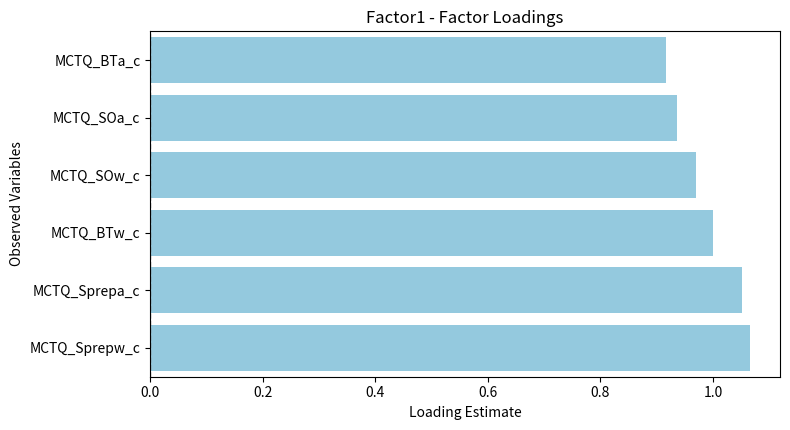

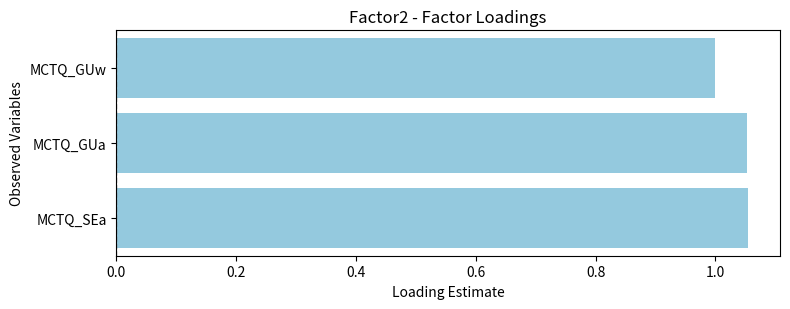

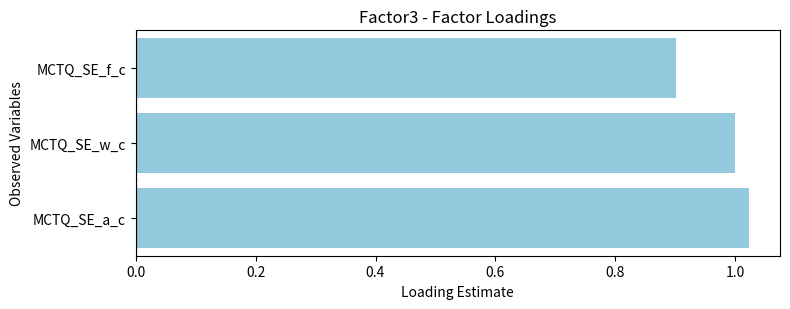

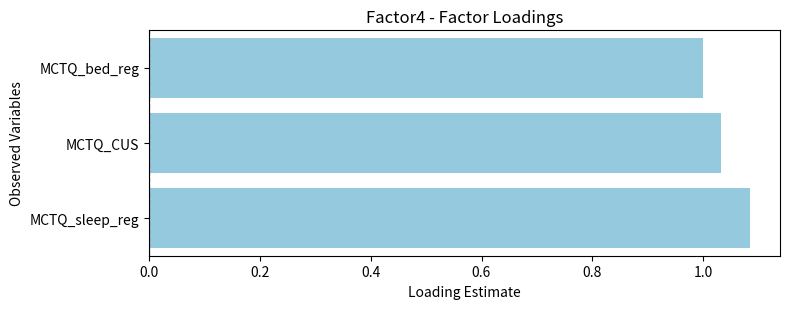

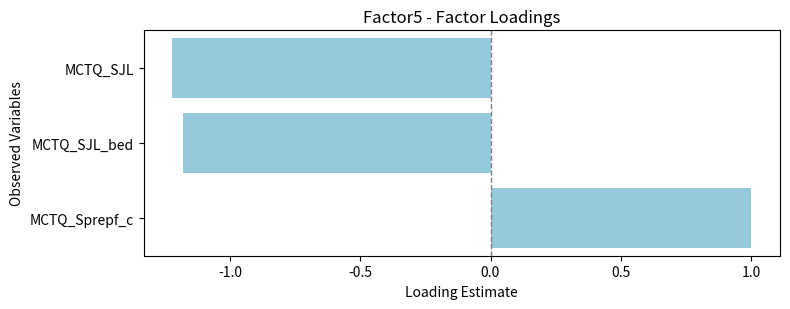

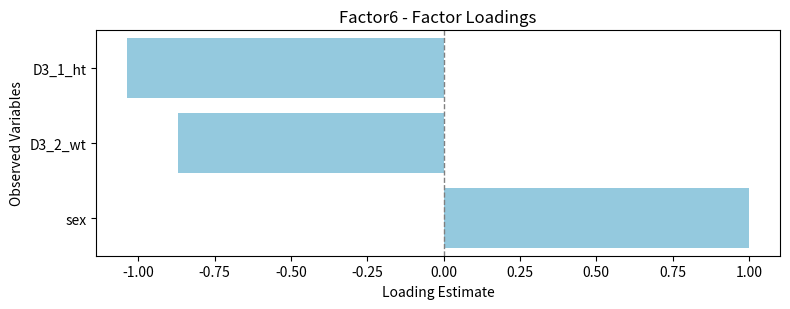

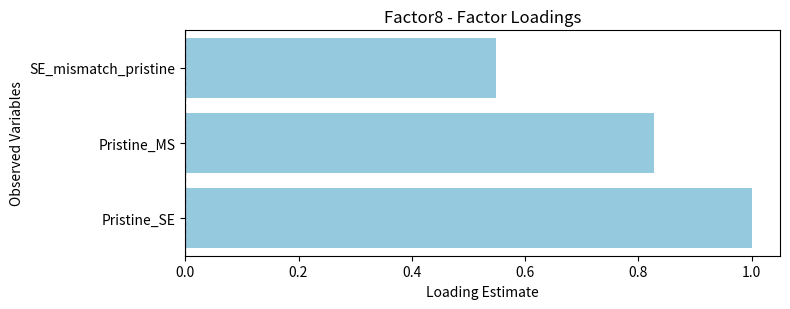

In [30]:
def plot_cfa_loadings_by_factor(est, save_figs=False, out_dir="./", use_std=True):
    """
    CFA 요인적재량을 요인별로 개별 시각화하는 함수.
    
    Parameters
    ----------
    est : pd.DataFrame
        semopy의 model.inspect() 결과 (lval, op, rval, Estimate 등 포함)
    save_figs : bool
        True면 각 요인별 그래프를 개별 PNG로 저장
    out_dir : str
        저장 경로 (save_figs=True일 때만 사용)
    use_std : bool
        True면 'Std.Estimate' 열 사용, 없으면 Estimate 사용
    """
    # 1️⃣ 요인적재량(=~)만 필터링
    df_load = est[est["op"] == "~"].copy()

    # 2️⃣ 컬럼 매핑 (semopy 구조에 맞게)
    # lval = 관찰변수, rval = 요인
    df_load = df_load.rename(columns={"lval": "Variable", "rval": "Factor"})

    # 3️⃣ 사용할 적재량 열 선택
    if use_std:
        std_cols = [c for c in df_load.columns if "std" in c.lower() and "est" in c.lower()]
        loading_col = std_cols[0] if std_cols else "Estimate"
    else:
        loading_col = "Estimate"

    # 4️⃣ 요인 목록 순회하며 개별 그래프 생성
    factors = sorted(df_load["Factor"].unique())
    for factor in factors:
        subset = df_load[df_load["Factor"] == factor].copy()
        subset = subset.sort_values(by=loading_col, ascending=True)

        plt.figure(figsize=(8, 0.4 * len(subset) + 2))
        sns.barplot(
            data=subset,
            y="Variable",
            x=loading_col,
            color="skyblue",
            orient="h"
        )
        plt.axvline(0, color='gray', linestyle='--', lw=1)
        plt.title(f"{factor} - Factor Loadings")
        plt.xlabel("Standardized Loading" if "std" in loading_col.lower() else "Loading Estimate")
        plt.ylabel("Observed Variables")
        plt.tight_layout()

        # 저장 여부
        if save_figs:
            filename = f"{out_dir.rstrip('/')}/{factor}_loadings.png"
            plt.savefig(filename, dpi=150, bbox_inches="tight")
            print(f"💾 {filename} 저장 완료")
        else:
            plt.show()

# ✅ 사용 예시
plot_cfa_loadings_by_factor(est, save_figs=False)

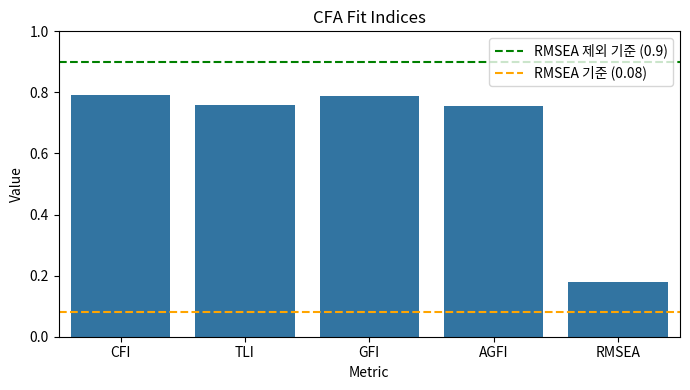

In [31]:
# 주요 적합도 지표만 추출
fit_indices = stats.loc["Value", ["CFI", "TLI", "GFI", "AGFI", "RMSEA"]]
fit_indices = fit_indices.reset_index()
fit_indices.columns = ["Metric", "Value"]

plt.figure(figsize=(7,4))
sns.barplot(data=fit_indices, x="Metric", y="Value")
plt.axhline(0.9, color="green", linestyle="--", label="RMSEA 제외 기준 (0.9)")
plt.axhline(0.08, color="orange", linestyle="--", label="RMSEA 기준 (0.08)")
plt.title("CFA Fit Indices")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()
